In [2]:
#Import databases and dependencies
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
import numpy as np
import numpy_financial as npf
import alpaca_trade_api as tradeapi
import requests
import json
import cryptowatch as cw
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import panel as pn
import altair as alt
from altair import datum
from vega_datasets import data
import datetime as dt
from pathlib import Path
from functools import reduce
from dotenv import load_dotenv
from pycoingecko import CoinGeckoAPI
from datetime import datetime, timedelta
from MCForecastTools import MCSimulation
%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv()

True

In [4]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [5]:
# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [6]:
# Set date
start_date = pd.Timestamp("2006-07-01", tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-01-01', tz='America/New_York').isoformat()

# Tickers for an all-weather set and forget portfolio 
tickers = ["SPY", "TLT", "IEF", "GLD", "DJP"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# 10 years of data
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:18: DeprecatedWarning: get_barset is deprecated as of v1.0.0. Use get_bars instead


In [7]:
df_stock_data.head()

DJP                                     GLD  \
                            open    high    low  close    volume    open   
time                                                                       
2018-01-10 00:00:00-05:00  24.59  24.590  24.44  24.49  597557.0     NaN   
2018-01-11 00:00:00-05:00  24.55  24.610  24.50  24.51  278556.0     NaN   
2018-01-12 00:00:00-05:00  24.58  24.720  24.53  24.72  304649.0  126.01   
2018-01-16 00:00:00-05:00  24.55  24.606  24.49  24.57  443871.0  126.60   
2018-01-17 00:00:00-05:00  24.60  24.715  24.56  24.67  627270.0  126.77   

                                                               ...     SPY  \
                             high     low    close     volume  ...    open   
time                                                           ...           
2018-01-10 00:00:00-05:00     NaN     NaN      NaN        NaN  ...     NaN   
2018-01-11 00:00:00-05:00     NaN     NaN      NaN        NaN  ...     NaN   
2018-01-12 00:00:00-05:00  127.13  125.81  126.975  7474319.0  ...  276.42   
2018-01-16 00:00:00-05:00  127.18  126.40  127.170  6614262.0  ...  279.35   
2018-01-17 00:00:00-05:00  127.22  125.90  126.140  8772608.0  ...  278.04   

                                                                  TLT          \
                             high     low   close      volume    open    high   
time                                                                            
2018-01-10 00:00:00-05:00     NaN     NaN     NaN         NaN  122.82  123.93   
2018-01-11 00:00:00-05:00     NaN     NaN     NaN         NaN  123.51  124.59   
2018-01-12 00:00:00-05:00  278.11  276.27  277.91  53855427.0  124.10  124.79   
2018-01-16 00:00:00-05:00  280.09  276.18  276.96  70240852.0  125.17  125.28   
2018-01-17 00:00:00-05:00  280.05  277.19  279.61  62162956.0  125.08  125.64   

                                                        
                               low   close      volume  
time                                                    
2018-01-10 00:00:00-05:00  122.660  123.79  10741191.0  
2018-01-11 00:00:00-05:00  123.310  124.30  10638074.0  
2018-01-12 00:00:00-05:00  123.910  124.53   7709191.0  
2018-01-16 00:00:00-05:00  124.560  125.03   7865423.0  
2018-01-17 00:00:00-05:00  124.595  124.89   6865138.0  

[5 rows x 25 columns]

In [8]:
df_stock_data.xs('close',level=1,axis=1)

,DJP,GLD,IEF,SPY,TLT
time,,,,,
2018-01-10 00:00:00-05:00,24.49,NaN,104.57,NaN,123.79
2018-01-11 00:00:00-05:00,24.51,NaN,104.65,NaN,124.30
2018-01-12 00:00:00-05:00,24.72,126.975,104.56,277.91,124.53
2018-01-16 00:00:00-05:00,24.57,127.170,104.61,276.96,125.03
2018-01-17 00:00:00-05:00,24.67,126.140,104.39,279.61,124.89
...,...,...,...,...,...
2021-12-27 00:00:00-05:00,29.13,169.370,115.35,477.27,148.86
2021-12-28 00:00:00-05:00,28.98,168.655,115.33,476.89,148.28
2021-12-29 00:00:00-05:00,29.05,168.590,114.77,477.46,146.66


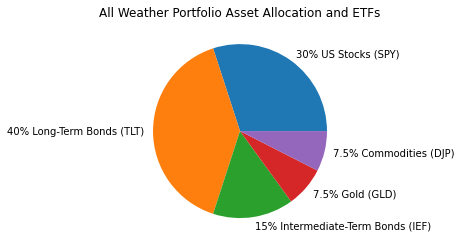

In [9]:
#visualise portfolio allocation
import matplotlib.pyplot as plt

y = np.array([30, 40, 15, 7.5, 7.5])
mylabels = ["30% US Stocks (SPY)", "40% Long-Term Bonds (TLT)", "15% Intermediate-Term Bonds (IEF)", "7.5% Gold (GLD)", "7.5% Commodities (DJP)"]
plt.pie(y, labels = mylabels)
plt.title("All Weather Portfolio Asset Allocation and ETFs")
plt.show() 

In [10]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.3, .4, .15, .075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*10
)
# Printing the simulation input data
MC_even_dist.portfolio_data.head(-10)

DJP                                      \
                            open     high      low  close     volume   
time                                                                   
2018-01-10 00:00:00-05:00  24.59  24.5900  24.4400  24.49   597557.0   
2018-01-11 00:00:00-05:00  24.55  24.6100  24.5000  24.51   278556.0   
2018-01-12 00:00:00-05:00  24.58  24.7200  24.5300  24.72   304649.0   
2018-01-16 00:00:00-05:00  24.55  24.6060  24.4900  24.57   443871.0   
2018-01-17 00:00:00-05:00  24.60  24.7150  24.5600  24.67   627270.0   
...                          ...      ...      ...    ...        ...   
2021-12-10 00:00:00-05:00  27.90  27.9600  27.7900  27.92  1035421.0   
2021-12-13 00:00:00-05:00  28.03  28.0800  27.8001  27.83    87574.0   
2021-12-14 00:00:00-05:00  27.60  27.6595  27.5155  27.61   685666.0   
2021-12-15 00:00:00-05:00  27.54  27.7300  27.3500  27.71   651419.0   
2021-12-16 00:00:00-05:00  27.84  28.1221  27.8200  27.97   592798.0   

                                           GLD                            ...  \
                          daily_return    open     high     low    close  ...   
time                                                                      ...   
2018-01-10 00:00:00-05:00          NaN     NaN      NaN     NaN      NaN  ...   
2018-01-11 00:00:00-05:00     0.000817     NaN      NaN     NaN      NaN  ...   
2018-01-12 00:00:00-05:00     0.008568  126.01  127.130  125.81  126.975  ...   
2018-01-16 00:00:00-05:00    -0.006068  126.60  127.180  126.40  127.170  ...   
2018-01-17 00:00:00-05:00     0.004070  126.77  127.220  125.90  126.140  ...   
...                                ...     ...      ...     ...      ...  ...   
2021-12-10 00:00:00-05:00     0.006852  166.72  166.915  166.18  166.590  ...   
2021-12-13 00:00:00-05:00    -0.003223  166.90  167.255  166.67  167.035  ...   
2021-12-14 00:00:00-05:00    -0.007905  165.34  166.140  165.16  165.450  ...   
2021-12-15 00:00:00-05:00     0.003622  165.29  166.400  163.80  166.150  ...   
2021-12-16 00:00:00-05:00     0.009383  167.01  168.180  166.94  168.170  ...   

                              SPY                                         TLT  \
                              low   close       volume daily_return      open   
time                                                                            
2018-01-10 00:00:00-05:00     NaN     NaN          NaN          NaN  122.8200   
2018-01-11 00:00:00-05:00     NaN     NaN          NaN          NaN  123.5100   
2018-01-12 00:00:00-05:00  276.27  277.91   53855427.0          NaN  124.1000   
2018-01-16 00:00:00-05:00  276.18  276.96   70240852.0    -0.003418  125.1700   
2018-01-17 00:00:00-05:00  277.19  279.61   62162956.0     0.009568  125.0800   
...                           ...     ...          ...          ...       ...   
2021-12-10 00:00:00-05:00  466.51  470.72   64958435.0     0.009392  149.9200   
2021-12-13 00:00:00-05:00  466.27  466.61   53533452.0    -0.008731  150.4000   
2021-12-14 00:00:00-05:00  460.25  463.39   84376354.0    -0.006901  150.3500   
2021-12-15 00:00:00-05:00  460.74  470.58   97945190.0     0.015516  149.6139   
2021-12-16 00:00:00-05:00  464.80  466.43  100111230.0    -0.008819  148.7500   

                                                                               
                              high      low    close      volume daily_return  
time                                                                           
2018-01-10 00:00:00-05:00  123.930  122.660  123.790  10741191.0          NaN  
2018-01-11 00:00:00-05:00  124.590  123.310  124.300  10638074.0     0.004120  
2018-01-12 00:00:00-05:00  124.790  123.910  124.530   7709191.0     0.001850  
2018-01-16 00:00:00-05:00  125.280  124.560  125.030   7865423.0     0.004015  
2018-01-17 00:00:00-05:00  125.640  124.595  124.890   6865138.0    -0.001120  
...                            ...      ...      ...         ...          ...  
2021-12-10 00:00:00-05:00  150

In [11]:
dat = pd.DataFrame(MC_even_dist.portfolio_data)
dat.head()

DJP                                               \
                            open    high    low  close    volume daily_return   
time                                                                            
2018-01-10 00:00:00-05:00  24.59  24.590  24.44  24.49  597557.0          NaN   
2018-01-11 00:00:00-05:00  24.55  24.610  24.50  24.51  278556.0     0.000817   
2018-01-12 00:00:00-05:00  24.58  24.720  24.53  24.72  304649.0     0.008568   
2018-01-16 00:00:00-05:00  24.55  24.606  24.49  24.57  443871.0    -0.006068   
2018-01-17 00:00:00-05:00  24.60  24.715  24.56  24.67  627270.0     0.004070   

                              GLD                           ...     SPY  \
                             open    high     low    close  ...     low   
time                                                        ...           
2018-01-10 00:00:00-05:00     NaN     NaN     NaN      NaN  ...     NaN   
2018-01-11 00:00:00-05:00     NaN     NaN     NaN      NaN  ...     NaN   
2018-01-12 00:00:00-05:00  126.01  127.13  125.81  126.975  ...  276.27   
2018-01-16 00:00:00-05:00  126.60  127.18  126.40  127.170  ...  276.18   
2018-01-17 00:00:00-05:00  126.77  127.22  125.90  126.140  ...  277.19   

                                                               TLT          \
                            close      volume daily_return    open    high   
time                                                                         
2018-01-10 00:00:00-05:00     NaN         NaN          NaN  122.82  123.93   
2018-01-11 00:00:00-05:00     NaN         NaN          NaN  123.51  124.59   
2018-01-12 00:00:00-05:00  277.91  53855427.0          NaN  124.10  124.79   
2018-01-16 00:00:00-05:00  276.96  70240852.0    -0.003418  125.17  125.28   
2018-01-17 00:00:00-05:00  279.61  62162956.0     0.009568  125.08  125.64   

                                                                     
                               low   close      volume daily_return  
time                                                                 
2018-01-10 00:00:00-05:00  122.660  123.79  10741191.0          NaN  
2018-01-11 00:00:00-05:00  123.310  124.30  10638074.0     0.004120  
2018-01-12 00:00:00-05:00  123.910  124.53   7709191.0     0.001850  
2018-01-16 00:00:00-05:00  124.560  125.03   7865423.0     0.004015  
2018-01-17 00:00:00-05:00  124.595  124.89   6865138.0    -0.001120  

[5 rows x 30 columns]

In [12]:
dat.xs('daily_return',level=1,axis=1)

,DJP,GLD,IEF,SPY,TLT
time,,,,,
2018-01-10 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN
2018-01-11 00:00:00-05:00,0.000817,NaN,0.000765,NaN,0.004120
2018-01-12 00:00:00-05:00,0.008568,NaN,-0.000860,NaN,0.001850
2018-01-16 00:00:00-05:00,-0.006068,0.001536,0.000478,-0.003418,0.004015
2018-01-17 00:00:00-05:00,0.004070,-0.008099,-0.002103,0.009568,-0.001120
...,...,...,...,...,...
2021-12-27 00:00:00-05:00,0.018888,0.002189,0.000347,0.014216,0.002424
2021-12-28 00:00:00-05:00,-0.005149,-0.004222,-0.000173,-0.000796,-0.003896
2021-12-29 00:00:00-05:00,0.002415,-0.000385,-0.004856,0.001195,-0.010925


In [13]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Admin\Desktop\group_project_1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007412,1.008081,1.001729,0.995250,0.996270,1.003903,1.009182,0.999341,1.001663,1.006716,...,1.003467,1.005543,1.002768,0.997645,1.003492,1.008689,1.004916,0.995372,1.004189,1.007614
2,1.006310,1.001369,1.002544,1.003291,0.998181,1.005743,1.013388,0.994847,1.002849,1.009184,...,1.001545,1.012355,1.003464,0.993933,1.002272,1.009887,1.010738,0.996135,1.011884,1.008863
3,1.008389,1.006923,1.001280,1.009555,0.995462,1.017363,1.018769,1.003569,0.999807,1.014305,...,1.002833,1.012599,0.996114,1.000379,0.997421,1.016768,1.002173,1.006435,1.004409,1.004936
4,1.013711,1.010837,0.994878,1.013371,1.000907,1.023014,1.019842,1.003557,1.000883,1.012587,...,1.006752,1.000765,1.009751,0.995389,0.992701,1.017168,0.996801,1.003926,1.004839,1.002614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.033885,1.758709,1.674566,1.777049,1.586238,2.322887,2.357881,1.244747,2.818225,2.362507,...,1.629669,2.873353,1.481902,2.285577,2.880307,1.364725,2.331901,1.520903,1.884283,2.743630
2517,1.031203,1.765462,1.659862,1.771885,1.590862,2.329682,2.369570,1.247474,2.823023,2.367869,...,1.613244,2.880292,1.480186,2.304142,2.903704,1.368736,2.331904,1.523936,1.883729,2.739722
2518,1.039767,1.768829,1.659650,1.768992,1.592611,2.335543,2.382978,1.238598,2.810185,2.358871,...,1.611978,2.891629,1.486343,2.307334,2.905378,1.362400,2.323491,1.530120,1.895051,2.749699
2519,1.039286,1.771994,1.665856,1.784771,1.598232,2.328828,2.382004,1.243476,2.820415,2.362218,...,1.605942,2.876600,1.487043,2.313762,2.905165,1.354971,2.332741,1.532330,1.900138,2.737316


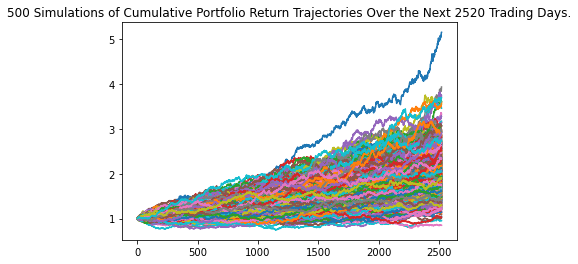

In [14]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

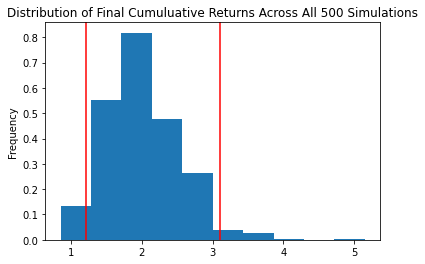

In [15]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean              2.009273
std               0.526995
min               0.848553
25%               1.650463
50%               1.938852
75%               2.321903
max               5.152974
95% CI Lower      1.202886
95% CI Upper      3.103832
Name: 2520, dtype: float64


In [17]:
# Set initial investment
initial_investment = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $100,000
ci_lower = round(even_tbl[8]*initial_investment,2)
ci_upper = round(even_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 10 years will end within in the range of $120288.65 and $310383.2


In [18]:
#Calculate cumulative returns for portfolio
cum_returns = MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Admin\Desktop\group_project_1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

In [19]:
# Reverse cumulative return function for further calculations
def reverse_cum_return(df):
    return (1 + df) / (1 + df.shift(1)) - 1

In [20]:
#Sharpe Ratio forecast
simulation_returns = cum_returns.apply(reverse_cum_return, axis = 0)
simulation_returns.dropna(inplace = True)
simulation_returns.isna().sum().sum()

0

In [21]:
mean_expectation_simulations = simulation_returns.mean(axis = 1)
mean_expectation_simulations

1       0.000145
2       0.000020
3       0.000258
4       0.000287
5       0.000432
          ...   
2516   -0.000034
2517    0.000235
2518    0.000112
2519    0.000111
2520   -0.000065
Length: 2520, dtype: float64

In [22]:
# Annual Sharpe Ratio
mean_expectation_simulations.mean() * 252 /(mean_expectation_simulations.std() * (252**0.5))

20.656524945133288

In [23]:
mean_expectation_simulations.std() * np.sqrt(252)
mean_expectation_simulations.mean() *252

0.04220508846569329

In [24]:
# Expected volatility for every day change
std_expectation_simu = simulation_returns.std(axis = 1) 

<AxesSubplot:>

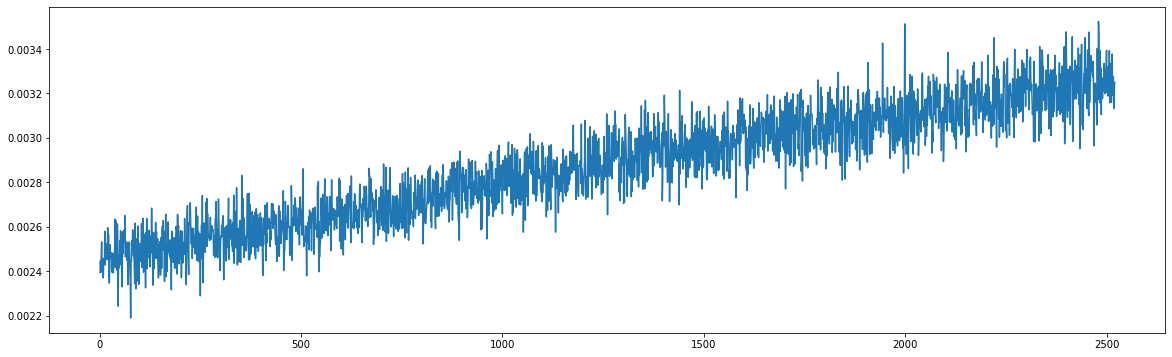

In [25]:
# Expected change for every simulation for every day in our returns (how much our rerun forecasts are changing every day based on the simulation of random numbers)
std_expectation_simu.plot(figsize = (20,6)) 

<AxesSubplot:>

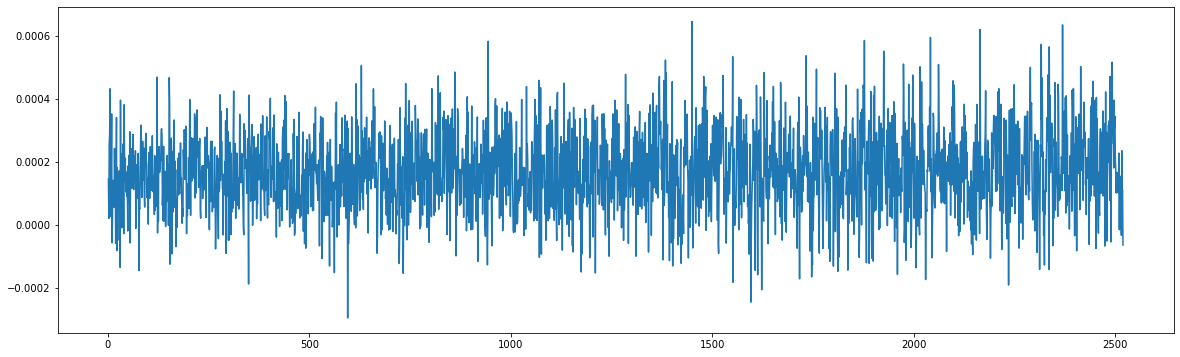

In [26]:
mean_expectation_simulations.plot(figsize = (20,6))

<AxesSubplot:>

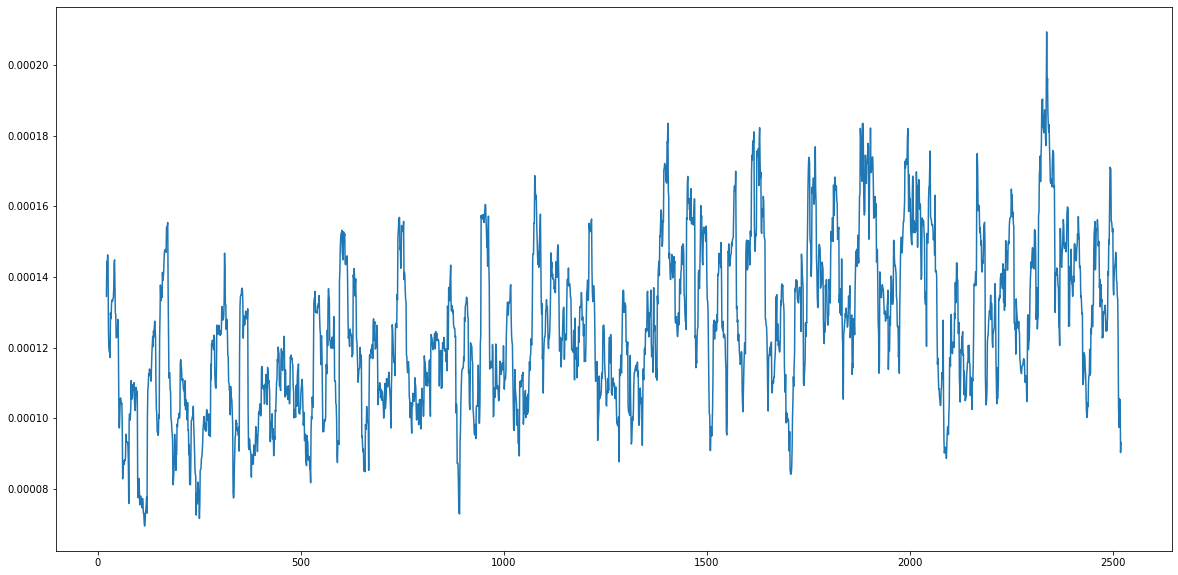

In [27]:
# Volatility of the expected simulation returns 
mean_expectation_simulations.rolling(21).std().plot(figsize = (20,10))

In [28]:
#Gaetano Yahoo Finance Portfolio

In [29]:
#creating variables for the tickers to use yfinance API functions
btc = yf.Ticker("BTC-USD")
eth = yf.Ticker("ETH-USD")
xrp = yf.Ticker("XRP-USD")
ada = yf.Ticker("ADA-USD")
link = yf.Ticker("LINK-USD")
doge = yf.Ticker("DOGE-USD")
ixic = yf.Ticker("^IXIC")
gspc = yf.Ticker("^GSPC")
axjo = yf.Ticker("^AXJO")

In [30]:
#creating functions that retrive specific data from API

def twoHundredDayAverage(tick):
    result = tick.info["twoHundredDayAverage"]
    return (f"200 Days Average Price is: ${result}")

def todayOpen(tick):
    result = tick.info["open"]
    return (f"Today open price is: ${result}")

def Volume(tick):
    result = tick.info["volume"]
    return (f"Today volume is: ${result}")

def marketCap(tick):
    result = tick.info["marketCap"]
    return (f"Market capitalization is: ${result}")

print(twoHundredDayAverage(eth))
print(todayOpen (eth))
print(Volume (eth))
print(marketCap (eth))

200 Days Average Price is: $3580.8315
Today open price is: $2620.0295
Today volume is: $11579544576
Market capitalization is: $326078431232


In [31]:
#importing data with yfinance API
crypto_df = yf.download("BTC-USD ETH-USD XRP-USD ADA-USD DOGE-USD LINK-USD USDT-USD BNB-USD THETA-USD XLM-USD" , start="2017-01-01", end= "2022-01-01")
index_df = yf.download("^IXIC ^GSPC ^AXJO", start="2017-01-01", end= "2022-01-01")
luke_df = yf.download("DJP SPY GLD TLT", start="2017-01-01", end= "2022-01-01")


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  4 of 4 completed


In [32]:
#calculate filter by close and calculate % change 
crypto_daily_change = crypto_df["Close"].pct_change().dropna()
index_daily_change = index_df["Close"].pct_change().dropna()
luke_daily_change = luke_df["Close"].pct_change().dropna()
crypto_daily_change.head()

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,THETA-USD,USDT-USD,XLM-USD,XRP-USD
Date,,,,,,,,,,
2018-01-18,0.048865,0.005435,0.025589,0.041972,0.021721,0.065264,0.067203,0.008457,0.067764,0.222178
2018-01-19,-0.014163,0.046231,0.011547,-0.012298,0.002721,0.092277,-0.077315,-0.018151,-0.006459,-0.027891
2018-01-20,0.087644,0.083645,0.111291,0.073307,0.111683,0.499929,0.052413,-0.003415,0.056190,0.017119
2018-01-21,-0.133351,-0.131066,-0.100712,-0.155895,-0.091391,-0.271854,-0.130751,-0.001248,-0.131968,-0.125793
2018-01-22,-0.069647,-0.074899,-0.057646,-0.055672,-0.044132,-0.095705,-0.069181,0.005180,0.047878,-0.016442


In [33]:
index_daily_change.head()

,^AXJO,^GSPC,^IXIC
Date,,,
2017-01-04,0.000558,0.005722,0.008827
2017-01-05,0.002946,-0.000771,0.001997
2017-01-06,0.000400,0.003517,0.006035
2017-01-09,0.009000,-0.003549,0.001949
2017-01-10,-0.008041,0.000000,0.003615


In [34]:
luke_daily_change

,DJP,GLD,SPY,TLT
Date,,,,
2017-01-04,0.010088,0.003530,0.005949,0.003845
2017-01-05,0.007907,0.015515,-0.000794,0.015654
2017-01-06,-0.004955,-0.007373,0.003578,-0.009182
2017-01-09,-0.012033,0.008233,-0.003301,0.008026
2017-01-10,0.005040,0.004260,0.000000,-0.000657
...,...,...,...,...
2021-12-23,0.000700,0.002254,0.006222,-0.008677
2021-12-27,0.018538,0.002367,0.014152,0.002424
2021-12-28,-0.005151,-0.004310,-0.000817,-0.003963


In [35]:
#concat dataframes
combined_df = pd.concat([crypto_daily_change, index_daily_change], axis="columns", join="inner")

combined_df

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,THETA-USD,USDT-USD,XLM-USD,XRP-USD,^AXJO,^GSPC,^IXIC
Date,,,,,,,,,,,,,
2018-01-18,0.048865,0.005435,0.025589,0.041972,0.021721,0.065264,0.067203,0.008457,0.067764,0.222178,-0.000199,-0.001616,-0.000306
2018-01-19,-0.014163,0.046231,0.011547,-0.012298,0.002721,0.092277,-0.077315,-0.018151,-0.006459,-0.027891,-0.001463,0.004385,0.005528
2018-01-22,-0.069647,-0.074899,-0.057646,-0.055672,-0.044132,-0.095705,-0.069181,0.005180,0.047878,-0.016442,-0.002314,0.008067,0.009766
2018-01-23,-0.012951,0.006062,-0.005763,-0.009059,-0.016976,-0.001172,-0.042118,0.000010,-0.000315,-0.014941,0.007527,0.002174,0.007055
2018-01-24,0.105028,0.040875,0.045177,0.061442,0.073564,-0.011290,0.448638,-0.007528,0.166251,0.015018,0.002932,-0.000560,-0.006063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.039056,0.028604,-0.003328,-0.012183,-0.007322,-0.001203,-0.006656,-0.000505,0.025529,0.005432,0.000000,0.013839,0.013920
2021-12-28,-0.073136,-0.049256,-0.060259,-0.072390,-0.058613,-0.112722,-0.069612,0.001224,-0.081419,-0.079060,0.000000,-0.001010,-0.005642
2021-12-29,-0.050953,-0.039122,-0.024042,-0.036481,-0.045348,-0.033769,-0.036200,-0.000873,-0.029617,-0.042494,0.012062,0.001402,-0.000982


In [108]:
#output concatenated dataframe highlighing days with highest gains/losses

combined_df.head(20).style.highlight_max(color = 'green').highlight_min(color = 'red')

,Gaetano Portfolio
Date,
2018-01-18 00:00:00,0.044025
2018-01-19 00:00:00,0.000381
2018-01-22 00:00:00,-0.031904
2018-01-23 00:00:00,-0.006190
2018-01-24 00:00:00,0.071806
2018-01-25 00:00:00,0.034387
2018-01-26 00:00:00,-0.010462
2018-01-29 00:00:00,-0.041966
2018-01-30 00:00:00,-0.101719


<AxesSubplot:xlabel='Date'>

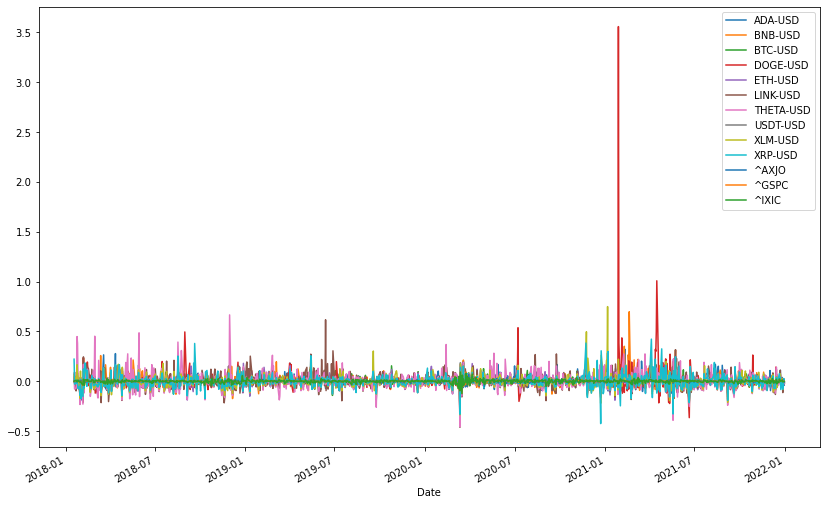

In [36]:
#plot daily returns
combined_df.plot(figsize=(14, 9))

In [37]:
#standard deviation 
combined_df.std()

ADA-USD      0.063336
BNB-USD      0.063749
BTC-USD      0.042217
DOGE-USD     0.135110
ETH-USD      0.053461
LINK-USD     0.075480
THETA-USD    0.084093
USDT-USD     0.004546
XLM-USD      0.066148
XRP-USD      0.065021
^AXJO        0.011091
^GSPC        0.013275
^IXIC        0.014877
dtype: float64

In [38]:
#plot cumulative returns

cum_returns = (1 + combined_df).cumprod() - 1

cum_returns.hvplot(width=1000, height=500)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Rolling Standard Deviation (21 days) for both porfolios'}, xlabel='Date'>

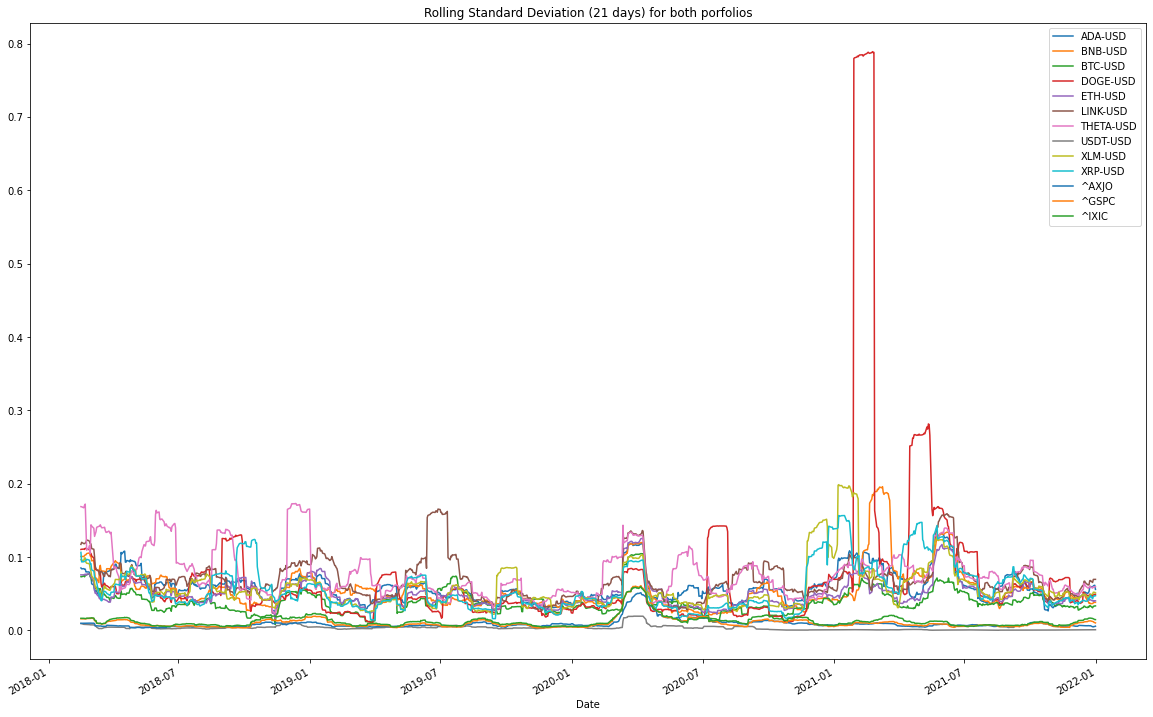

In [39]:
#calculating rolling standard deviation of the combined porfolio
combined_df.rolling(window =21).std().plot(title = "Rolling Standard Deviation (21 days) for both porfolios", figsize=(20, 13))

In [40]:
#correlation
correlation = combined_df.corr()
correlation.style.background_gradient(cmap="winter")

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,THETA-USD,USDT-USD,XLM-USD,XRP-USD,^AXJO,^GSPC,^IXIC
ADA-USD,1.000000,0.617243,0.703346,0.309079,0.779123,0.613820,0.512905,-0.040749,0.756302,0.671262,0.102549,0.232928,0.241962
BNB-USD,0.617243,1.000000,0.658689,0.211280,0.685504,0.559988,0.453346,-0.037811,0.540532,0.545477,0.077820,0.205174,0.218362
BTC-USD,0.703346,0.658689,1.000000,0.324549,0.837119,0.615686,0.516033,-0.000975,0.641245,0.636393,0.116027,0.237822,0.256333
DOGE-USD,0.309079,0.211280,0.324549,1.000000,0.303464,0.269815,0.196804,0.013186,0.339664,0.277290,-0.011530,0.095893,0.089086
ETH-USD,0.779123,0.685504,0.837119,0.303464,1.000000,0.688831,0.553700,-0.037482,0.695806,0.708412,0.117226,0.253017,0.268037
LINK-USD,0.613820,0.559988,0.615686,0.269815,0.688831,1.000000,0.447893,0.012733,0.578779,0.556973,0.074970,0.217920,0.229426
THETA-USD,0.512905,0.453346,0.516033,0.196804,0.553700,0.447893,1.000000,-0.032162,0.454609,0.446357,0.087448,0.185248,0.186821
USDT-USD,-0.040749,-0.037811,-0.000975,0.013186,-0.037482,0.012733,-0.032162,1.000000,-0.017686,-0.031772,-0.145996,-0.145735,-0.121335
XLM-USD,0.756302,0.540532,0.641245,0.339664,0.695806,0.578779,0.454609,-0.017686,1.000000,0.720349,0.074951,0.206695,0.204225
XRP-USD,0.671262,0.545477,0.636393,0.277290,0.708412,0.556973,0.446357,-0.031772,0.720349,1.000000,0.060517,0.186147,0.196395


In [41]:
#sharpe ratios
sharpe_ratio_stocks = (index_daily_change.mean() *252) / (index_daily_change.std() * np.sqrt(252))
sharpe_ratio_crypto = (crypto_daily_change.mean() *365) / (crypto_daily_change.std() * np.sqrt(365))

stock_pl = px.bar(sharpe_ratio_stocks, title="Stock Market Sharpe Ratios")
crypto_pl =px.bar(sharpe_ratio_crypto, title="Crypto Market Sharpe Ratios" )

In [42]:
tabs = pn.Tabs(
    ("Stock", stock_pl),
    ("Crypto", crypto_pl)
    
    
    
)
tabs

Tabs
    [0] Plotly(Figure, name='Stock')
    [1] Plotly(Figure, name='Crypto')

In [43]:
#Rhoan All USD Crypto Pair Portfolio

In [44]:
# setting up api
cryptowatch_api_key = os.getenv("CRYPTOWATCH_API_KEY")
cw.api_key = cryptowatch_api_key

In [45]:
##Getting historical data

# Set the tickers
markets = ("binance:btcaud")

# This will return a list of 1 day candles, each candle being a list with:
# [close_timestamp, open, high, low, close, volume_base, volume_quote]
candles = cw.markets.get(
    "binance:btcaud",
    ohlc=True
)
daily_candles = candles.of_1d[:-30]
print(json.dumps(daily_candles, indent=4))

[
    [
        1596240000.0,
        15250.0,
        16086.12,
        15199.99,
        15985.33,
        5.693647,
        89869.26097271
    ],
    [
        1596326400.0,
        16030.06,
        16727.03,
        15883.64,
        16641.21,
        13.679593,
        224302.52565097
    ],
    [
        1596412800.0,
        16682.68,
        17073.14,
        15230.44,
        15572.34,
        20.604389,
        327564.11798205
    ],
    [
        1596499200.0,
        15576.84,
        16236.38,
        15576.84,
        15901.75,
        19.635283,
        311281.16150978
    ],
    [
        1596585600.0,
        15901.75,
        16139.98,
        15630.39,
        15703.31,
        11.078404,
        175538.07974448
    ],
    [
        1596672000.0,
        15719.34,
        16523.46,
        15611.82,
        16299.96,
        17.394859,
        277782.88669345
    ],
    [
        1596758400.0,
        16482.59,
        17088.88,
        16203.25,
        16361.56,
 

In [46]:
# find the price and date of the btc
btc_value = daily_candles[0][4]
btc_date = daily_candles[0][0]
print(btc_date)
print(btc_value)

1596240000.0
15985.33


In [47]:
#Get a list of the btc closing price
btc_closing_price = np.array(daily_candles)
#Get a list of the btc closing price
btc_closing_price_date = np.array(daily_candles)

In [48]:
#convert arrays into pandas dataframes
df_btc = pd.DataFrame(btc_closing_price)
df_btc = df_btc.set_axis(["Date","Open","High","Low","Close","Volume_base","Volume_quote"], axis=1, inplace=False)
df_btc["Date"] = pd.to_datetime(df_btc["Date"],unit="s")
df_btc.set_index("Date", inplace=True)
df_btc.head(1)

,Open,High,Low,Close,Volume_base,Volume_quote
Date,,,,,,
2020-08-01,15250.0,16086.12,15199.99,15985.33,5.693647,89869.260973


In [49]:
# Created a shifted column to calculate difference between each data entry in close
df_btc['shifted_column'] = df_btc["Close"].shift(1)

# Calculate the difference between each data entry
df_btc["Difference"] = df_btc["Close"] - df_btc["shifted_column"]

#Calculate the percentage change from 'close' (the 'shifted_column' is the correct answer)
df_btc["BTC"] = df_btc["Difference"] / df_btc["shifted_column"]

#drop the unused columns
df_btc.drop(["shifted_column", "Close", "Difference", "Open","High", "Low", "Volume_base", "Volume_quote"], axis=1, inplace=True)

In [50]:
df_btc.head()

,BTC
Date,
2020-08-01,NaN
2020-08-02,0.041030
2020-08-03,-0.064230
2020-08-04,0.021154
2020-08-05,-0.012479


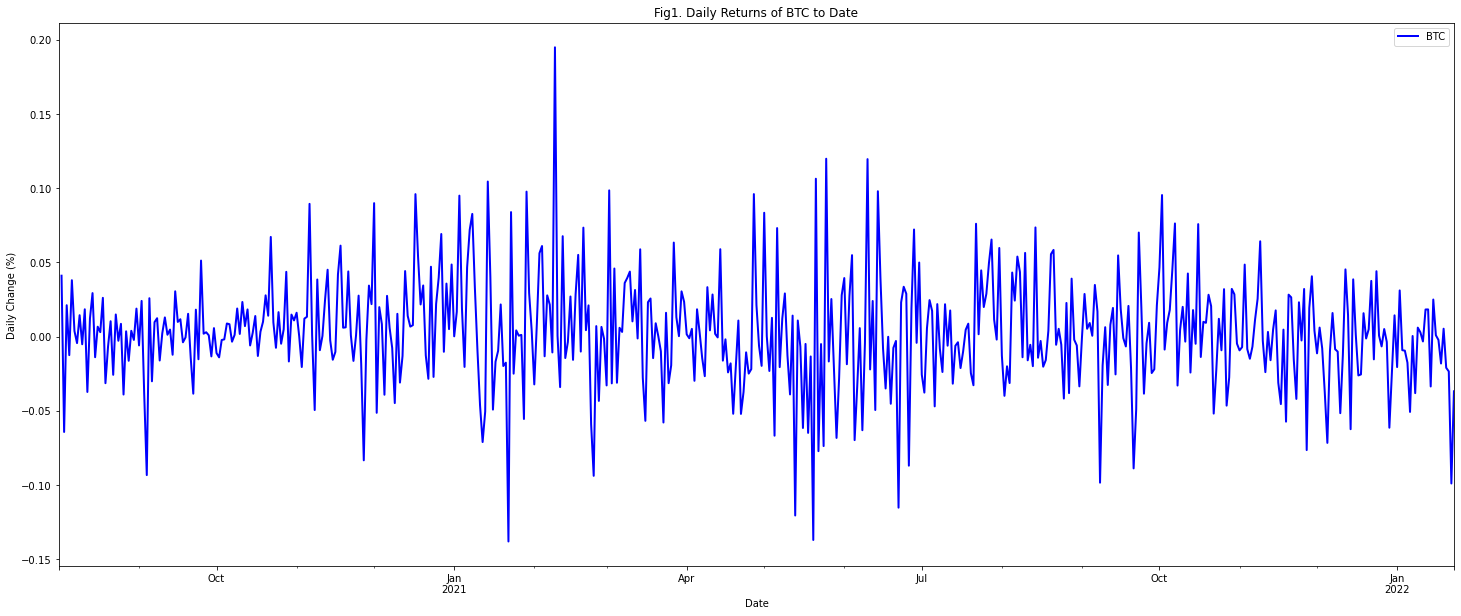

In [51]:
#Calculate and plot daily returns of btc portfolio
daily_returns = df_btc
dr = daily_returns.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig1. Daily Returns of BTC to Date", ylabel="Daily Change (%)", xlabel="Date")

<AxesSubplot:title={'center':'Fig2. Daily Cumulative Returns of BTC to date'}, xlabel='Date', ylabel='Daily Return (%)'>

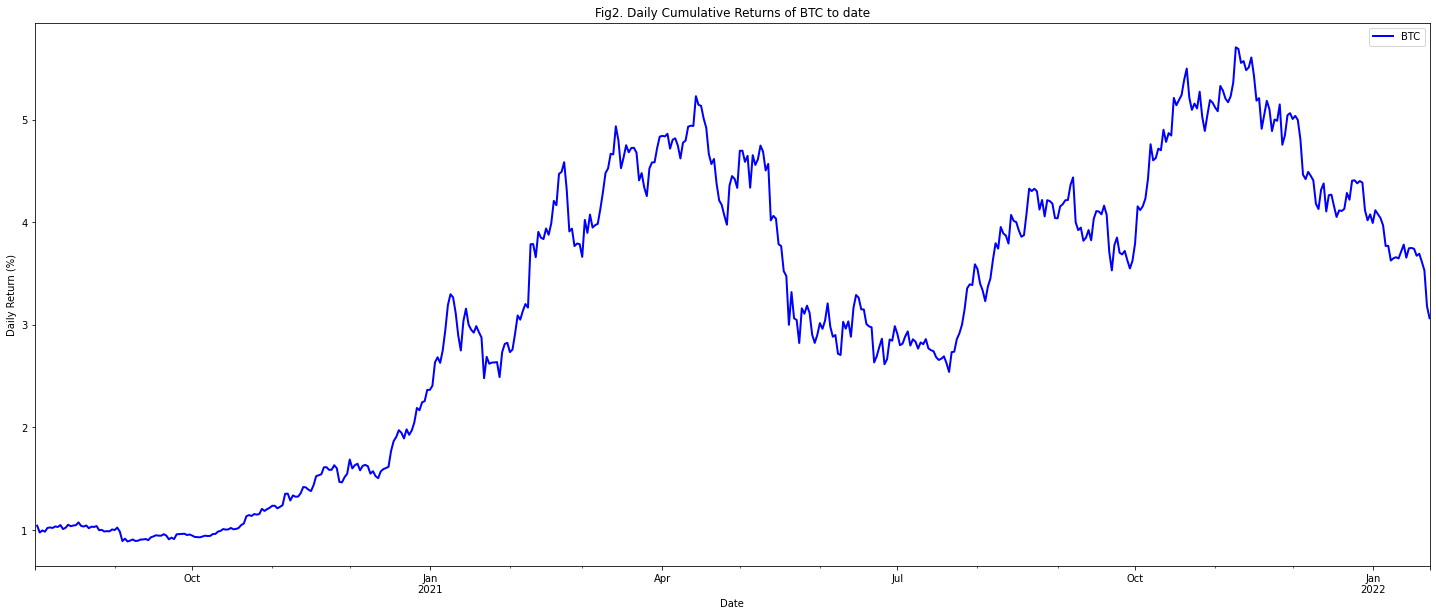

In [52]:
# Calculate and plot cumulative returns for all portfolios. Does any portfolio outperform BTC?
df_cum = (1+ daily_returns).cumprod()
df_cum.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig2. Daily Cumulative Returns of BTC to date", ylabel="Daily Return (%)", xlabel="Date")

<AxesSubplot:title={'center':'Fig3. Daily Returns Box Plot'}, ylabel='% Change'>

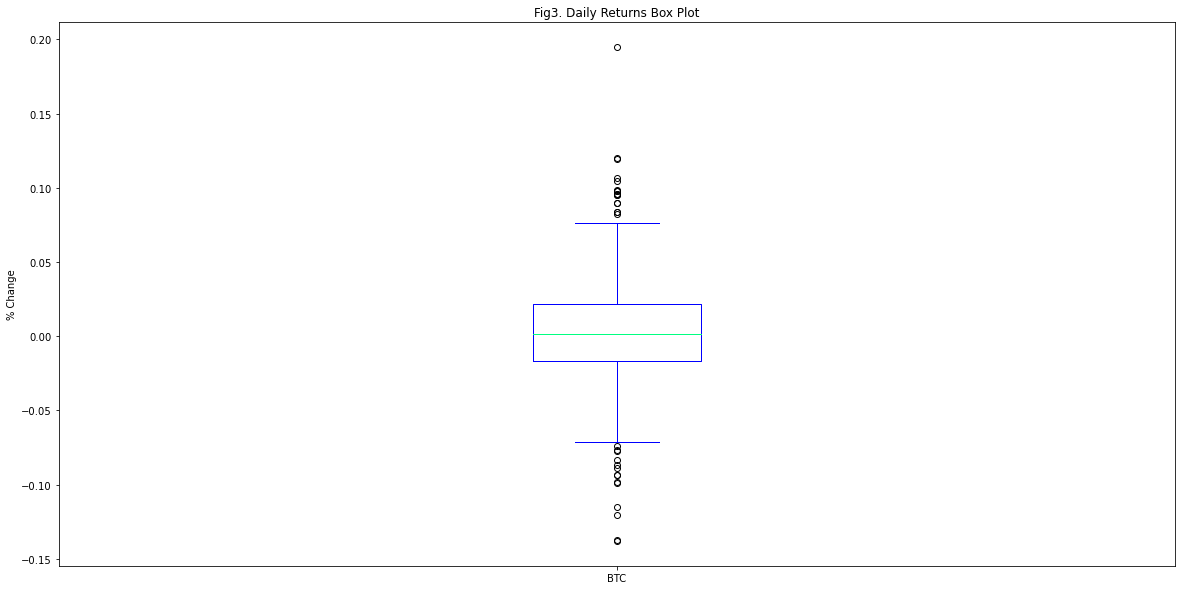

In [53]:
# Create a box plot for each of the returns.
daily_returns.plot(kind = "box", colormap="winter", figsize = (20,10), ylabel="% Change", title="Fig3. Daily Returns Box Plot")

In [54]:
# Daily Standard Deviations
# Calculate the standard deviation for each portfolio.
df_daily_std = pd.DataFrame(daily_returns.std()).rename(columns = {0:"std"})
df_daily_std

,std
BTC,0.037707


In [55]:
cw.exchanges.list()

<ExchangeListAPIResponse([<Exchange(Binance)>, <Exchange(Zonda)>, <Exchange(Kraken Futures)>, <Exchange(Poloniex)>, <Exchange(FTX.US)>, <Exchange(Quoine)>, <Exchange(BitVC)>, <Exchange(BTC China)>, <Exchange(BitMEX)>, <Exchange(Huobi)>, <Exchange(Coinbase Pro)>, <Exchange(796)>, <Exchange(QuadrigaCX)>, <Exchange(NYMEX (Beta))>, <Exchange(WEX)>, <Exchange(CEX.IO)>, <Exchange(meXBT)>, <Exchange(Vault of Satoshi)>, <Exchange(Mt. Gox)>, <Exchange(FTX)>, <Exchange(CME (Beta))>, <Exchange(HitBTC)>, <Exchange(Gate.io)>, <Exchange(Binance.US)>, <Exchange(Liquid)>, <Exchange(bitFlyer)>, <Exchange(OKCoin)>, <Exchange(Bithumb)>, <Exchange(OKX)>, <Exchange(Deribit)>, <Exchange(Uniswap V2)>, <Exchange(Bitfinex)>, <Exchange(Bittrex)>, <Exchange(DEX (aggregated))>, <Exchange(Bisq)>, <Exchange(Coinone)>, <Exchange(Bit-Z)>, <Exchange(Bitstamp)>, <Exchange(Kraken)>, <Exchange(Cryptsy)>, <Exchange(Gemini)>, <Exchange(Luno)>, <Exchange(CBOT)>, <Exchange(COMEX (Beta))>])>

In [56]:
# Get all binance markets
binance = cw.markets.list("binance")
price_dict={}
# For each binance market...
for market in binance.markets:
    
    # Forge current market ticker, like Binance:BTCUSD
    ticker = "{}:{}".format(market.exchange, market.pair).upper()
    #pull only aud pairs
    if market.pair[-3:] == "usd":
        # Request weekly candles for that market
        candles = cw.markets.get(ticker, ohlc=True, periods=["1d"])
        price_dict[market.pair] = candles.of_1d[:-1]
        
#print(candles.of_1m[:-30])

AttributeError: 'MarketOHLCAPIResponse' object has no attribute 'of_1d'

In [57]:
#create an individual data frame from the binance usd market
binance_btcaud_df = pd.DataFrame(price_dict["xrptusd"])
binance_btcaud_df.head()

,0,1,2,3,4,5,6
0,1.544227e+09,0.33597,0.33770,0.27901,0.29756,272729.1,80767.133658
1,1.544314e+09,0.29912,0.35343,0.29066,0.30545,1352127.9,409054.804204
2,1.544400e+09,0.30597,0.31750,0.29545,0.30791,1027537.4,316204.800745
3,1.544486e+09,0.30970,0.31761,0.29108,0.29173,1023826.3,304718.350174
4,1.544573e+09,0.29846,0.30836,0.28800,0.29736,708629.7,211866.150007


In [58]:
##df_btc = pd.DataFrame(btc_closing_price)
binance_btcaud_df = binance_btcaud_df.set_axis(["Date","Open","High","Low","Close","Volume_base","Volume_quote"], axis=1, inplace=False)
binance_btcaud_df["Date"] = pd.to_datetime(binance_btcaud_df["Date"],unit="s")
binance_btcaud_df.set_index("Date", inplace=True)
binance_btcaud_df.head()

,Open,High,Low,Close,Volume_base,Volume_quote
Date,,,,,,
2018-12-08,0.33597,0.33770,0.27901,0.29756,272729.1,80767.133658
2018-12-09,0.29912,0.35343,0.29066,0.30545,1352127.9,409054.804204
2018-12-10,0.30597,0.31750,0.29545,0.30791,1027537.4,316204.800745
2018-12-11,0.30970,0.31761,0.29108,0.29173,1023826.3,304718.350174
2018-12-12,0.29846,0.30836,0.28800,0.29736,708629.7,211866.150007


In [59]:
#loop through the dictionary and display dataframe with symbol
df_dict={}
returns_df=pd.DataFrame()
for sym in price_dict.keys():
    print('****', sym)
    sub_df = pd.DataFrame(price_dict[sym])
    sub_df = sub_df.set_axis(["Date","Open","High","Low","Close","Volume_base","Volume_quote"], axis=1, inplace=False)
    sub_df["Date"] = pd.to_datetime(sub_df["Date"],unit="s")
    sub_df.set_index("Date", inplace=True)
    sub_df['Returns'] = sub_df['Close'].pct_change()
    display(sub_df.head())
    df_dict[sym] = sub_df
    returns_df[sym] = sub_df['Returns']

**** xrptusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2018-12-08,0.33597,0.33770,0.27901,0.29756,272729.1,80767.133658,NaN
2018-12-09,0.29912,0.35343,0.29066,0.30545,1352127.9,409054.804204,0.026516
2018-12-10,0.30597,0.31750,0.29545,0.30791,1027537.4,316204.800745,0.008054
2018-12-11,0.30970,0.31761,0.29108,0.29173,1023826.3,304718.350174,-0.052548
2018-12-12,0.29846,0.30836,0.28800,0.29736,708629.7,211866.150007,0.019299


**** eostusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2018-12-08,1.6201,1.7728,1.5177,1.7078,88238.11,144817.868437,NaN
2018-12-09,1.7234,1.9852,1.6084,1.8079,554024.26,980289.351251,0.058613
2018-12-10,1.7976,2.1269,1.7183,1.9870,341292.77,647939.949241,0.099065
2018-12-11,1.9820,2.0706,1.8300,1.8300,151900.79,297384.684434,-0.079014
2018-12-12,1.9150,1.9498,1.7667,1.8396,150077.39,272984.920093,0.005246


**** xlmtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2018-12-08,0.11400,0.12896,0.08400,0.11552,574387.3,63821.040167,NaN
2018-12-09,0.11531,0.12440,0.10801,0.11567,1969643.7,227293.768433,0.001298
2018-12-10,0.11758,0.12843,0.11005,0.12134,1337223.7,160472.014689,0.049019
2018-12-11,0.12125,0.13500,0.11168,0.11217,1804489.3,211866.635468,-0.075573
2018-12-12,0.11516,0.12028,0.10908,0.11099,2102890.7,237122.672910,-0.010520


**** neotusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2018-12-20,7.000,9.550,6.497,6.593,27137.325,188095.959281,NaN
2018-12-21,6.494,7.600,6.492,7.176,59291.492,418054.055088,0.088427
2018-12-22,7.113,7.386,6.537,6.834,48421.617,342305.997104,-0.047659
2018-12-23,6.832,7.045,6.627,7.012,23927.804,164761.612236,0.026046
2018-12-24,7.049,7.994,6.000,7.556,115308.461,880049.567991,0.077581


**** adatusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2018-12-20,0.03704,0.03827,0.03391,0.03392,14206937.0,5.122327e+05,NaN
2018-12-21,0.03385,0.03990,0.03352,0.03885,15197451.1,5.684120e+05,0.145342
2018-12-22,0.03899,0.04481,0.03801,0.04060,29281509.2,1.198784e+06,0.045045
2018-12-23,0.04034,0.04195,0.03810,0.04169,6784485.5,2.718477e+05,0.026847
2018-12-24,0.04194,0.04454,0.04120,0.04416,14610700.1,6.236435e+05,0.059247


**** trxtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2018-12-20,0.01640,0.01745,0.01521,0.01535,23872084.4,3.857480e+05,NaN
2018-12-21,0.01531,0.01742,0.01517,0.01709,27653573.8,4.621747e+05,0.113355
2018-12-22,0.01700,0.02246,0.01687,0.01974,111670571.7,2.217877e+06,0.155061
2018-12-23,0.01972,0.02116,0.01830,0.02074,48418864.1,9.725092e+05,0.050659
2018-12-24,0.02089,0.02191,0.02015,0.02065,26342876.8,5.501134e+05,-0.004339


**** paxtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-01-09,1.0099,1.0099,0.9900,0.9973,74403.87,74297.391430,NaN
2019-01-10,0.9974,1.0001,0.9970,0.9984,85485.58,85317.677497,0.001103
2019-01-11,0.9984,0.9998,0.9940,0.9973,387864.60,386858.473753,-0.001102
2019-01-12,0.9974,0.9990,0.9954,0.9976,360985.11,359878.300231,0.000301
2019-01-13,0.9962,0.9995,0.9955,0.9971,120780.42,120521.368498,-0.000501


**** usdctusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-01-09,1.0007,1.0007,0.9996,0.9999,13685.77,1.368490e+04,NaN
2019-01-10,0.9999,1.0001,0.9993,0.9995,77052.78,7.701129e+04,-0.000400
2019-01-11,0.9995,1.0001,0.9980,0.9992,1371925.20,1.371046e+06,-0.000300
2019-01-12,0.9992,1.0000,0.9978,0.9982,464102.31,4.635679e+05,-0.001001
2019-01-13,0.9989,0.9998,0.9970,0.9994,267692.31,2.673730e+05,0.001202


**** linktusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-01-17,0.5603,0.5603,0.4510,0.4971,42122.17,20439.576762,NaN
2019-01-18,0.4750,0.4949,0.4685,0.4763,296627.36,142219.069293,-0.041843
2019-01-19,0.4763,0.5073,0.4636,0.4982,111477.41,52756.226156,0.045979
2019-01-20,0.4878,0.5031,0.4700,0.4844,81850.50,39261.062452,-0.027700
2019-01-21,0.4826,0.5104,0.4589,0.4845,51104.60,24357.316035,0.000206


**** wavestusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-01-19,2.5890,2.6046,2.4902,2.5245,9294.53,23637.252489,NaN
2019-01-20,2.5454,2.6575,2.5122,2.5700,13727.95,35490.056589,0.018023
2019-01-21,2.5672,2.6147,2.4212,2.4939,16900.89,42540.915190,-0.029611
2019-01-22,2.5070,2.5335,2.4580,2.5039,9340.02,23319.734867,0.004010
2019-01-23,2.4997,2.8143,2.4021,2.7625,253924.41,676594.017623,0.103279


**** bchtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-01-23,120.08,130.95,115.57,127.14,4178.23172,525308.660489,NaN
2019-01-24,127.29,134.26,126.60,131.20,2389.76876,310946.179010,0.031933
2019-01-25,130.69,130.69,125.96,127.93,2356.59331,302934.935443,-0.024924
2019-01-26,128.22,128.25,124.92,126.75,1989.41851,251093.761632,-0.009224
2019-01-27,126.65,128.53,125.04,125.04,2315.34754,292075.732431,-0.013491


**** bsvtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-01-23,73.86,75.79,72.72,75.30,1156.98093,86414.106836,NaN
2019-01-24,75.30,75.98,74.49,74.78,753.28375,56663.157674,-0.006906
2019-01-25,74.68,74.68,73.30,73.84,2269.60594,167534.518172,-0.012570
2019-01-26,73.84,75.76,73.15,73.98,1685.63741,125489.789654,0.001896
2019-01-27,73.91,75.28,72.94,73.11,556.19862,41275.747422,-0.011760


**** ltctusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-01-25,31.27,32.94,31.27,32.48,3183.21981,103325.872057,NaN
2019-01-26,32.56,32.99,31.91,32.67,5136.60549,166637.348729,0.005850
2019-01-27,32.59,33.86,32.56,32.64,2603.78317,85700.570968,-0.000918
2019-01-28,32.63,33.00,31.24,32.20,4494.52243,145245.837983,-0.013480
2019-01-29,32.00,32.23,29.88,30.97,3853.00213,118918.570967,-0.038199


**** bttoldtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-02-23,0.000997,0.000997,0.000980,0.000982,12310661.0,12095.922008,NaN
2019-02-24,0.000980,0.001001,0.000500,0.000995,205972419.0,196443.071765,0.013647
2019-02-25,0.000988,0.001016,0.000707,0.000858,274257166.0,255307.655719,-0.137948
2019-02-26,0.000868,0.000892,0.000800,0.000863,206555629.0,179565.159390,0.005478
2019-02-27,0.000868,0.000873,0.000833,0.000861,103285611.0,88052.383642,-0.001507


**** usdstusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-02-24,0.9999,1.0001,0.9998,1.0000,135189.96,135180.063347,NaN
2019-02-25,0.9999,1.0001,0.9913,0.9996,657115.91,657021.467686,-0.0004
2019-02-26,0.9991,1.0001,0.9977,0.9996,73955.94,73943.239238,0.0000
2019-02-27,1.0000,1.0000,0.9977,0.9996,25883.65,25870.910891,0.0000
2019-02-28,0.9999,1.0001,0.9990,0.9999,125068.40,125058.840218,0.0003


**** bnbtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-03-14,16.7293,16.7293,14.8652,14.9653,9119.49,1.368735e+05,NaN
2019-03-15,14.9062,14.9852,14.4739,14.7800,29809.21,4.386581e+05,-0.012382
2019-03-16,14.7800,15.0506,14.7500,14.8419,17317.29,2.580210e+05,0.004188
2019-03-17,14.8039,15.9090,10.2000,15.8635,64354.95,9.880161e+05,0.068832
2019-03-18,15.8635,15.8635,15.3739,15.5209,126644.10,1.969098e+06,-0.021597


**** btctusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-03-14,3872.00,3872.00,3826.45,3852.28,140.590810,5.422902e+05,NaN
2019-03-15,3847.42,3903.93,3783.07,3849.38,595.836516,2.295148e+06,-0.000753
2019-03-16,3852.01,3912.00,3843.57,3895.53,533.471594,2.067565e+06,0.011989
2019-03-17,3895.64,4050.00,3892.92,3983.95,741.863592,2.946186e+06,0.022698
2019-03-18,3983.97,3984.60,3927.37,3963.05,600.973047,2.374324e+06,-0.005246


**** ethtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-03-14,132.17,132.43,129.99,131.04,1143.34448,1.499905e+05,NaN
2019-03-15,131.01,134.30,129.06,131.39,7574.76578,9.921287e+05,0.002671
2019-03-16,131.56,136.54,131.56,135.25,5034.70860,6.730165e+05,0.029378
2019-03-17,135.83,143.27,134.10,140.40,8508.46482,1.190396e+06,0.038078
2019-03-18,139.91,140.01,136.40,137.88,4483.97220,6.184839e+05,-0.017949


**** zectusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-03-22,57.49,58.23,53.77,55.08,6765.80922,377420.030566,NaN
2019-03-23,55.10,56.28,54.39,55.04,5241.42960,289305.014026,-0.000726
2019-03-24,54.98,56.47,54.90,56.47,1314.21209,72939.408601,0.025981
2019-03-25,56.50,57.64,56.23,56.89,1919.45635,109464.775594,0.007438
2019-03-26,56.61,56.61,53.81,54.92,557.80736,30878.946504,-0.034628


**** atomtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-05-08,4.970,4.990,4.403,4.600,2196.077,7541.662581,NaN
2019-05-09,4.440,4.615,4.240,4.290,7815.614,0.000000,-0.067391
2019-05-10,4.370,4.440,3.443,3.689,8529.025,32668.589755,-0.140093
2019-05-11,4.039,4.039,3.580,3.731,18655.039,70271.923721,0.011385
2019-05-12,3.881,4.180,3.669,3.903,13504.311,53493.249985,0.046100


**** battusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-05-09,0.3009,0.3210,0.3009,0.3069,27378.49,0.000000,NaN
2019-05-10,0.3163,0.3164,0.2756,0.2785,199756.70,56492.156212,-0.092538
2019-05-11,0.2997,0.3799,0.2380,0.3600,326095.78,108304.006079,0.292639
2019-05-12,0.3618,0.3864,0.3156,0.3623,599024.17,215659.331508,0.006389
2019-05-13,0.3750,0.4022,0.3338,0.3430,338945.06,125733.741611,-0.053271


**** etctusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-05-09,5.000,6.000,5.000,5.710,113.142,0.000000,NaN
2019-05-10,5.871,5.872,5.430,5.562,535.019,1983.652138,-0.025919
2019-05-11,5.625,5.625,5.480,5.581,117.504,657.497156,0.003416
2019-05-12,5.619,6.407,5.442,5.915,4269.131,25163.736266,0.059846
2019-05-13,5.961,6.200,5.710,5.767,935.601,5484.051343,-0.025021


**** tfueltusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-05-25,0.02560,0.02560,0.00930,0.01516,13235818.5,195980.654123,NaN
2019-05-26,0.01607,0.02577,0.01568,0.02185,24167193.7,516975.077040,0.441293
2019-05-27,0.02215,0.02300,0.01684,0.01775,16117797.4,308480.002513,-0.187643
2019-05-28,0.01784,0.01834,0.01510,0.01657,15256847.6,258178.001601,-0.066479
2019-05-29,0.01660,0.01703,0.01522,0.01639,5182387.4,83439.877167,-0.010863


**** ftmtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-06-12,0.04001,0.05000,0.02500,0.03300,5168138.0,191759.229296,NaN
2019-06-13,0.03213,0.03368,0.03100,0.03179,2036585.8,65201.194258,-0.036667
2019-06-14,0.03215,0.03570,0.02615,0.03045,1710458.3,54537.223658,-0.042152
2019-06-15,0.03006,0.03102,0.02536,0.02738,1653153.5,46280.307747,-0.100821
2019-06-16,0.02755,0.02998,0.02607,0.02707,1025233.7,28147.267297,-0.011322


**** bcpttusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-06-20,0.07000,0.07000,0.05940,0.06000,655827.1,41263.740925,NaN
2019-06-21,0.06196,0.06197,0.05499,0.05499,508254.5,29349.604357,-0.083500
2019-06-22,0.05505,0.05800,0.05452,0.05452,51071.9,2855.324457,-0.008547
2019-06-23,0.05470,0.05939,0.05300,0.05550,37597.0,2032.670472,0.017975
2019-06-24,0.05850,0.06300,0.05649,0.05700,46163.2,2698.988465,0.027027


**** onetusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-06-26,0.01973,0.02005,0.01911,0.01923,708251.6,13801.711396,NaN
2019-06-27,0.01920,0.01963,0.01665,0.01807,6745038.1,122134.123808,-0.060322
2019-06-28,0.01810,0.01933,0.01655,0.01922,1415423.4,24994.556391,0.063641
2019-06-29,0.01846,0.02001,0.01800,0.01841,1482612.8,27772.300167,-0.042144
2019-06-30,0.01866,0.02209,0.01800,0.02028,4251244.3,86857.523091,0.101575


**** algotusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-06-29,1.434,1.521,1.420,1.437,6830.521,10013.590261,NaN
2019-06-30,1.437,1.511,1.391,1.500,23437.875,34028.381367,0.043841
2019-07-01,1.505,1.571,1.377,1.434,25273.784,37517.774757,-0.044000
2019-07-02,1.431,1.431,1.240,1.332,18153.840,24056.018501,-0.071130
2019-07-03,1.317,1.317,0.929,1.140,47364.270,53543.016140,-0.144144


**** gtotusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-07-02,0.02000,0.03496,0.00420,0.02869,298942.0,5524.911841,NaN
2019-07-03,0.02579,0.02644,0.02533,0.02644,27236.3,707.264819,-0.078425
2019-07-04,0.02644,0.02814,0.02512,0.02512,142637.6,3917.050949,-0.049924
2019-07-05,0.02523,0.02575,0.02413,0.02575,24658.9,602.486842,0.025080
2019-07-06,0.02403,0.02504,0.02395,0.02395,297479.0,7284.111863,-0.069903


**** ankrtusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-07-24,0.01200,0.01200,0.00830,0.00940,292082.3,2769.455414,NaN
2019-07-25,0.00737,0.00923,0.00650,0.00650,893718.1,6518.342552,-0.308511
2019-07-26,0.00678,0.00678,0.00675,0.00675,33099.6,223.739189,0.038462
2019-07-27,0.00675,0.00693,0.00650,0.00693,32544.0,220.504979,0.026667
2019-07-28,0.00724,0.00724,0.00650,0.00650,29021.9,192.801688,-0.062049


**** bnbbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-08,14.9047,16.0309,14.9004,16.0309,4751.86,73385.524757,NaN
2019-10-09,15.9870,16.3158,15.8382,15.9772,1082.77,17357.557232,-0.003350
2019-10-10,16.0576,18.0000,15.9264,17.7662,10099.48,174155.689636,0.111972
2019-10-11,17.7542,17.9261,17.0798,17.6407,2908.21,50825.561144,-0.007064
2019-10-12,17.5970,17.6850,16.5550,16.5865,4217.67,71686.208075,-0.059760


**** btcbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-08,7829.06,8290.04,7793.52,8237.68,41.409387,336166.210570,NaN
2019-10-09,8217.83,8325.58,8114.65,8185.61,22.099533,181625.601173,-0.006321
2019-10-10,8196.59,8662.59,8129.69,8581.34,57.824688,489857.510046,0.048345
2019-10-11,8587.06,8650.91,8458.53,8576.00,32.459087,277809.645635,-0.000622
2019-10-12,8564.94,8798.63,8234.82,8261.18,61.820489,521398.681928,-0.036709


**** xrpbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-22,0.30000,0.30000,0.28859,0.29236,238669.1,69662.292680,NaN
2019-10-23,0.29185,0.30291,0.28918,0.29049,501959.9,148569.937380,-0.006396
2019-10-24,0.28913,0.29131,0.24940,0.27327,894342.6,243044.205017,-0.059279
2019-10-25,0.27308,0.27955,0.26673,0.27806,487432.4,131752.647427,0.017528
2019-10-26,0.27528,0.30696,0.27436,0.29815,809081.8,235045.871987,0.072251


**** ethbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-22,175.00,177.89,171.87,174.29,460.19617,80505.318215,NaN
2019-10-23,174.24,175.13,170.34,171.31,647.82578,112352.327308,-0.017098
2019-10-24,171.24,171.53,153.36,162.46,1130.90732,183037.249140,-0.051661
2019-10-25,162.34,163.50,158.44,161.00,808.86735,130011.074978,-0.008987
2019-10-26,161.02,186.73,161.00,181.74,1762.18861,305820.576710,0.128820


**** bchbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-22,225.00,236.19,223.79,232.34,215.03849,49815.378323,NaN
2019-10-23,232.03,234.08,226.00,226.96,215.85311,49799.815027,-0.023156
2019-10-24,227.34,227.72,197.81,210.12,465.31281,98681.846384,-0.074198
2019-10-25,210.04,217.63,206.09,212.29,602.53908,126872.608391,0.010327
2019-10-26,213.23,272.08,212.01,259.48,795.54553,193641.723460,0.222290


**** ltcbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-22,54.00,55.75,53.00,54.71,986.23969,53951.810433,NaN
2019-10-23,54.61,55.06,53.13,53.42,1211.64921,65992.611813,-0.023579
2019-10-24,53.30,53.43,47.59,49.52,2595.33421,130129.376200,-0.073006
2019-10-25,49.47,50.30,48.34,49.98,2468.99991,121775.846240,0.009289
2019-10-26,49.59,58.37,49.12,57.04,4221.79647,228456.470251,0.141257


**** linkbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-22,2.6000,2.6668,2.5500,2.6299,4813.51,12526.846272,NaN
2019-10-23,2.6268,2.8143,2.5729,2.6074,22869.57,61990.460073,-0.008555
2019-10-24,2.5844,2.6764,2.3838,2.6084,28789.11,73107.851875,0.000384
2019-10-25,2.6155,2.7742,2.6085,2.7309,29412.32,79209.099553,0.046964
2019-10-26,2.7228,2.9936,2.6244,2.8432,35520.42,99257.933811,0.041122


**** etcbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-10-22,4.5000,4.6827,4.4399,4.6091,5418.39,24803.715261,NaN
2019-10-23,4.6120,4.6432,4.4297,4.4542,3416.19,15595.045022,-0.033607
2019-10-24,4.4686,4.4829,4.0475,4.2326,12334.03,52743.119907,-0.049751
2019-10-25,4.2495,4.3598,4.0182,4.2682,13769.02,58744.635194,0.008411
2019-10-26,4.2666,4.9856,4.2388,4.7558,12230.78,55392.008510,0.114240


**** trxbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-11-08,0.02000,76.99992,0.00613,0.01949,9681292.1,188690.712750,NaN
2019-11-09,0.01949,0.01973,0.01831,0.01874,22588737.5,430922.139717,-0.038481
2019-11-10,0.01874,0.01910,0.01868,0.01893,5776778.2,108977.198677,0.010139
2019-11-11,0.01891,0.01980,0.01886,0.01933,12397358.9,239791.214887,0.021130
2019-11-12,0.01933,0.01934,0.01865,0.01904,11933306.6,227034.799123,-0.015003


**** eosbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-11-08,3.6000,3.6000,1.3005,3.4626,10108.81,35023.898056,NaN
2019-11-09,3.4633,3.5476,3.3281,3.4044,22837.78,79112.708409,-0.016808
2019-11-10,3.4025,3.4964,3.4025,3.4870,18463.04,63828.163030,0.024263
2019-11-11,3.4828,3.7932,3.4424,3.5797,21384.94,76177.690172,0.026584
2019-11-12,3.5815,3.5925,3.4027,3.4295,16853.08,58555.802573,-0.041959


**** xlmbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-11-29,0.05890,0.05896,0.05731,0.05731,76642.6,4477.877514,NaN
2019-11-30,0.05814,0.05996,0.05799,0.05916,142258.3,8368.817831,0.032281
2019-12-01,0.05897,0.05922,0.05682,0.05732,154313.9,8942.552132,-0.031102
2019-12-02,0.05711,0.05759,0.05514,0.05739,169670.9,9537.153327,0.001221
2019-12-03,0.05722,0.05722,0.05560,0.05608,111775.6,6276.896459,-0.022826


**** adabusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-11-29,0.03911,0.03976,0.03835,0.03905,380894.8,14823.642883,NaN
2019-11-30,0.03902,0.04198,0.03902,0.04126,1735211.6,71043.842184,0.056594
2019-12-01,0.04112,0.04207,0.03988,0.04038,454810.4,18656.365231,-0.021328
2019-12-02,0.04016,0.04023,0.03821,0.03964,331302.9,12992.417682,-0.018326
2019-12-03,0.03949,0.03949,0.03746,0.03810,316556.5,12107.731500,-0.038850


**** qtumbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-12-07,1.735,4.850,1.520,1.750,5067.708,8785.638270,NaN
2019-12-08,1.749,1.765,1.736,1.748,2740.568,4793.096328,-0.001143
2019-12-09,1.738,1.763,1.721,1.747,2762.285,4801.725278,-0.000572
2019-12-10,1.732,1.777,1.721,1.737,4191.111,7336.516574,-0.005724
2019-12-11,1.724,1.762,1.694,1.746,3654.735,6328.120036,0.005181


**** vetbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2019-12-07,0.068580,0.070000,0.006514,0.006958,10187916.0,68440.917864,NaN
2019-12-08,0.006980,0.007276,0.006846,0.006846,5931309.0,42094.640769,-0.016097
2019-12-09,0.006891,0.007303,0.006662,0.007134,4345523.0,30233.460423,0.042068
2019-12-10,0.007123,0.007365,0.006785,0.006839,3943404.0,27914.136717,-0.041351
2019-12-11,0.006796,0.006846,0.005972,0.006216,11156786.0,70521.208479,-0.091095


**** eurbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-01-04,1.1162,1.1181,1.1145,1.1177,4538.46,5066.227846,NaN
2020-01-05,1.1139,1.1172,1.1139,1.1172,6323.54,7064.436402,-0.000447
2020-01-06,1.1172,1.1172,1.1139,1.1172,1141.40,1275.131523,0.000000
2020-01-07,1.1172,5.0000,1.1155,1.1210,37948.88,42578.035076,0.003401
2020-01-08,1.1210,1.1210,1.1142,1.1146,24283.39,27132.855846,-0.005709


**** bullbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-01-18,13250.00,13250.00,12565.77,13027.65,19.888073,254651.960106,NaN
2020-01-19,12993.27,13195.53,12600.00,13033.33,7.140146,92500.768623,0.000436
2020-01-20,12966.66,14200.00,11256.24,12037.74,13.262514,166181.923997,-0.076388
2020-01-21,12064.11,12159.41,11288.50,11711.86,24.452408,286662.337552,-0.027072
2020-01-22,11732.05,12248.18,11166.76,12144.37,25.614449,301820.578258,0.036929


**** bearbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-01-18,21.90,22.97,21.86,22.26,4307.62558,97224.016131,NaN
2020-01-19,22.45,22.94,21.72,22.27,4419.82804,99229.306561,0.000449
2020-01-20,22.31,25.10,20.34,23.95,11752.89038,276854.125276,0.075438
2020-01-21,23.77,25.39,23.67,24.51,8635.63336,211231.320986,0.023382
2020-01-22,24.58,25.68,23.38,23.71,10017.20391,243243.654263,-0.032640


**** ethbullbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-04,5400.00,5429.00,1341.52,1354.84,99.682685,136375.486334,NaN
2020-02-05,1399.80,1417.70,1269.71,1342.81,74.581416,98864.089789,-0.008879
2020-02-06,1353.84,1753.64,1333.53,1674.28,237.752625,382170.559717,0.246848
2020-02-07,1678.57,1957.03,1603.57,1875.00,206.418458,374627.128960,0.119884
2020-02-08,1881.25,2159.37,1881.25,2143.12,281.556890,578973.625589,0.142997


**** ethbearbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-04,43.94,44.30,41.96,42.78,701.82156,3.044854e+04,NaN
2020-02-05,42.65,46.44,41.84,44.12,1531.48674,6.852832e+04,0.031323
2020-02-06,43.81,44.03,31.70,33.62,15250.23737,5.471603e+05,-0.237987
2020-02-07,33.63,35.07,27.97,29.60,33139.33910,1.020286e+06,-0.119572
2020-02-08,29.43,29.43,24.84,25.21,42288.33654,1.125111e+06,-0.148311


**** icxbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-07,0.4595,0.9995,0.2400,0.4400,5552.50,3012.716472,NaN
2020-02-08,0.4661,0.4661,0.3965,0.4106,210659.18,87695.947644,-0.066818
2020-02-09,0.4095,0.4357,0.3824,0.4091,242305.05,98865.158730,-0.003653
2020-02-10,0.4036,0.4580,0.4017,0.4364,289928.73,125295.947893,0.066732
2020-02-11,0.4356,0.4456,0.3957,0.4062,159559.87,66721.824036,-0.069203


**** btsbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-07,0.03151,0.05550,0.01504,0.05550,237796.1,7096.648200,NaN
2020-02-08,0.03093,0.03275,0.03093,0.03216,156054.5,4941.218706,-0.420541
2020-02-09,0.03193,0.03240,0.02943,0.03104,162431.5,5051.148625,-0.034826
2020-02-10,0.03148,0.03812,0.03148,0.03630,918981.5,32590.261483,0.169459
2020-02-11,0.03711,0.03722,0.03314,0.03469,275347.3,9532.777731,-0.044353


**** bntbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-07,0.2831,1.0000,0.1236,0.3024,28671.47,8197.055200,NaN
2020-02-08,0.2949,0.3148,0.2900,0.3132,9369.73,2777.188415,0.035714
2020-02-09,0.3098,0.3196,0.3036,0.3153,16868.41,5298.381618,0.006705
2020-02-10,0.3117,0.3162,0.3108,0.3162,3319.18,1038.683073,0.002854
2020-02-11,0.3204,0.3204,0.3018,0.3067,8812.12,2728.604471,-0.030044


**** atombusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-12,4.691,21.000,4.691,5.137,4954.497,24941.756117,NaN
2020-02-13,5.136,5.339,5.060,5.146,12023.568,62651.393902,0.001752
2020-02-14,5.138,5.268,4.834,4.882,15968.030,81888.196095,-0.051302
2020-02-15,4.890,5.120,4.890,5.108,3788.437,18889.278842,0.046293
2020-02-16,5.135,5.141,4.403,4.586,9426.812,44093.742049,-0.102193


**** dashbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-12,123.55,525.00,123.55,129.73,179.98390,23465.189969,NaN
2020-02-13,129.72,136.94,128.86,133.86,606.33463,80814.013449,0.031835
2020-02-14,132.80,137.79,127.86,130.05,579.28765,76450.767888,-0.028463
2020-02-15,131.07,134.52,128.14,132.70,148.49668,19408.030184,0.020377
2020-02-16,133.00,133.24,115.95,120.01,457.88214,57205.019822,-0.095629


**** neobusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-12,13.123,23.996,13.006,13.852,1659.605,22775.628634,NaN
2020-02-13,13.881,15.311,13.881,14.755,5843.864,86170.413333,0.065189
2020-02-14,14.887,15.809,14.569,15.142,6196.643,94928.525317,0.026228
2020-02-15,15.122,16.723,14.866,16.658,3523.056,56350.346897,0.100119
2020-02-16,16.580,16.596,14.534,15.042,3874.222,60327.122710,-0.097010


**** wavesbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-12,1.3650,2.1895,1.3650,1.4491,29731.87,43675.252252,NaN
2020-02-13,1.4228,1.5269,1.4199,1.4435,31422.86,46488.137731,-0.003864
2020-02-14,1.4200,1.4456,1.3710,1.3994,8080.08,11386.811409,-0.030551
2020-02-15,1.3900,1.5584,1.3692,1.5522,14494.45,21550.367920,0.109190
2020-02-16,1.5416,1.7055,1.4600,1.4946,33321.48,52862.087023,-0.037109


**** xtzbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-12,2.5550,9.5000,2.5550,2.9178,55305.25,154919.338243,NaN
2020-02-13,2.9282,3.5792,2.9282,3.3073,121734.35,396911.195512,0.133491
2020-02-14,3.2929,3.3805,2.9067,3.1182,98794.26,309676.352807,-0.057177
2020-02-15,3.1374,3.5557,3.0595,3.4854,51447.68,173508.637166,0.117760
2020-02-16,3.5006,3.5424,2.9834,3.1621,64385.81,207048.692427,-0.092758


**** batbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-15,0.3001,0.3148,0.2970,0.3121,12171.75,3791.734351,NaN
2020-02-16,0.3113,0.3191,0.2737,0.2847,47800.16,13868.013626,-0.087792
2020-02-17,0.2756,0.2886,0.2450,0.2646,130628.98,34660.845590,-0.070601
2020-02-18,0.2616,0.2686,0.2401,0.2686,200044.62,50072.142061,0.015117
2020-02-19,0.2648,0.2905,0.2629,0.2811,64897.58,17803.848282,0.046538


**** enjbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-15,0.13660,0.14496,0.13557,0.14348,41823.1,5846.774939,NaN
2020-02-16,0.14318,0.15333,0.13107,0.13303,99649.8,14182.691911,-0.072832
2020-02-17,0.13204,0.13618,0.10956,0.12298,411581.6,51051.063202,-0.075547
2020-02-18,0.12331,0.15697,0.11010,0.13694,591170.1,82706.380213,0.113514
2020-02-19,0.13548,0.14586,0.13084,0.13997,538593.2,74531.531421,0.022126


**** nanobusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-15,1.0866,1.1379,1.0754,1.1210,3441.45,3779.987964,NaN
2020-02-16,1.1389,1.2170,1.0368,1.1114,37779.81,42233.019517,-0.008564
2020-02-17,1.1135,1.1894,0.9472,1.0699,46540.85,49087.836023,-0.037340
2020-02-18,1.0647,1.0658,0.9078,1.0025,34165.27,33412.545532,-0.062997
2020-02-19,0.9923,1.0242,0.9664,1.0140,8576.10,8507.256061,0.011471


**** ontbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-15,1.0188,5.0000,1.0032,1.0732,7680.76,8034.649397,NaN
2020-02-16,1.0836,1.0984,0.9388,0.9613,40258.31,40450.416041,-0.104268
2020-02-17,0.9586,1.0026,0.8214,0.9035,100621.34,91008.355919,-0.060127
2020-02-18,0.9017,0.9094,0.8079,0.8774,158838.84,133995.822930,-0.028888
2020-02-19,0.8825,0.9402,0.8365,0.9306,51694.42,45815.236386,0.060634


**** rvnbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-15,0.04088,0.04900,0.03820,0.04030,215269.2,8531.763393,NaN
2020-02-16,0.04024,0.04118,0.03594,0.03681,575091.3,21759.213279,-0.086600
2020-02-17,0.03692,0.03812,0.03196,0.03523,867473.7,29912.804262,-0.042923
2020-02-18,0.03400,0.03400,0.03008,0.03330,1571912.9,50175.133841,-0.054783
2020-02-19,0.03307,0.03489,0.03168,0.03472,437515.1,14320.222701,0.042643


**** stratbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-20,0.4555,0.4975,0.4400,0.4477,6182.39,2825.536697,NaN
2020-02-21,0.4242,0.4314,0.4175,0.4198,687.11,289.896173,-0.062319
2020-02-22,0.4320,0.4419,0.4320,0.4378,5354.03,2333.985445,0.042878
2020-02-23,0.4387,0.4741,0.4335,0.4566,8564.71,3854.531522,0.042942
2020-02-24,0.4541,0.4699,0.4520,0.4595,8296.58,3787.178711,0.006351


**** aionbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-20,0.1208,0.1281,0.1150,0.1159,11371.18,1312.459306,NaN
2020-02-21,0.1173,0.1291,0.1171,0.1291,8889.28,1070.386245,0.113891
2020-02-22,0.1237,0.1390,0.1237,0.1260,44189.23,5872.462070,-0.024012
2020-02-23,0.1333,0.1475,0.1258,0.1419,36952.55,4951.441933,0.126190
2020-02-24,0.1440,0.1714,0.1319,0.1622,173009.83,27001.636885,0.143058


**** algobusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-28,0.3776,0.3929,0.3654,0.3705,55806.80,21210.306496,NaN
2020-02-29,0.3798,0.3827,0.3350,0.3526,148314.58,52363.425579,-0.048313
2020-03-01,0.3507,0.3705,0.3236,0.3236,272788.20,92466.386737,-0.082246
2020-03-02,0.3251,0.3451,0.3087,0.3193,93550.12,30256.545291,-0.013288
2020-03-03,0.3165,0.3894,0.3133,0.3727,171513.72,60499.085807,0.167241


**** bttoldbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-28,0.000371,0.001800,0.000366,0.000379,18963385.0,7230.859698,NaN
2020-02-29,0.000380,0.000393,0.000350,0.000373,16018974.0,5888.350746,-0.014256
2020-03-01,0.000377,0.000377,0.000357,0.000363,14040175.0,5181.592671,-0.028656
2020-03-02,0.000357,0.000369,0.000354,0.000358,12459114.0,4498.033308,-0.012407
2020-03-03,0.000360,0.000388,0.000355,0.000379,15941082.0,6049.114371,0.057789


**** tomobusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-28,0.5032,0.5455,0.4988,0.5262,16072.65,8290.408467,NaN
2020-02-29,0.5152,0.5308,0.4838,0.5084,21105.65,10744.295953,-0.033827
2020-03-01,0.5085,0.5306,0.4914,0.4914,28273.72,14620.111945,-0.033438
2020-03-02,0.4947,0.5050,0.4638,0.4711,40513.08,19574.118852,-0.041311
2020-03-03,0.4761,0.5233,0.4761,0.5152,30276.67,15345.514095,0.093611


**** xmrbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-28,70.09,72.53,68.99,70.33,52.64246,3721.713590,NaN
2020-02-29,70.88,70.96,66.12,69.13,81.82942,5557.710355,-0.017062
2020-03-01,68.60,68.97,65.97,65.97,164.22354,11027.289770,-0.045711
2020-03-02,66.12,67.63,63.72,64.73,219.41826,14568.096784,-0.018796
2020-03-03,64.73,69.12,64.32,68.42,239.24694,15890.030665,0.057006


**** zecbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-28,52.59,55.02,51.96,52.80,252.50060,13501.783255,NaN
2020-02-29,52.98,53.86,48.57,50.84,636.01526,32406.695964,-0.037121
2020-03-01,51.27,51.82,49.12,49.12,1207.35857,60988.310587,-0.033832
2020-03-02,48.97,51.20,48.05,49.05,1220.95315,60692.084770,-0.001425
2020-03-03,48.93,52.73,48.78,52.49,796.36551,40636.095036,0.070133


**** databusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-04-08,0.04082,0.09998,0.04082,0.04304,712430.6,31486.011003,NaN
2020-04-09,0.04290,0.04625,0.04188,0.04375,1461102.5,64489.998114,0.016496
2020-04-10,0.04393,0.04467,0.04221,0.04311,1156008.4,50445.553036,-0.014629
2020-04-11,0.04311,0.04346,0.03620,0.03806,1640783.9,64912.346385,-0.117142
2020-04-12,0.03818,0.03930,0.03614,0.03727,1186463.7,45183.332050,-0.020757


**** erdbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-05-16,0.001805,0.001824,0.001775,0.001803,5388811.0,9675.163130,NaN
2020-05-17,0.001801,0.001934,0.001801,0.001874,5523254.0,10426.831637,0.039379
2020-05-18,0.001891,0.001923,0.001891,0.001902,6435169.0,12314.382058,0.014941
2020-05-19,0.001908,0.001925,0.001885,0.001920,1898472.0,3621.917022,0.009464
2020-05-20,0.001932,0.002099,0.001932,0.002063,10005060.0,20186.645820,0.074479


**** ctsibusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-05-18,0.02893,0.03987,0.02893,0.03714,2055465.5,69301.188627,NaN
2020-05-19,0.03703,0.04350,0.02938,0.03587,2972792.2,113261.738099,-0.034195
2020-05-20,0.03638,0.03972,0.03334,0.03770,1392232.7,50277.450651,0.051018
2020-05-21,0.03798,0.04045,0.03415,0.03894,1560496.6,59123.528543,0.032891
2020-05-22,0.03892,0.04351,0.03281,0.03300,1036499.0,39299.749426,-0.152542


**** hbarbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-05-23,0.03627,0.04699,0.03627,0.03754,354926.7,13257.148724,NaN
2020-05-24,0.03758,0.03844,0.03664,0.03689,471524.4,17589.175435,-0.017315
2020-05-25,0.03688,0.03916,0.03619,0.03690,586796.0,22001.442381,0.000271
2020-05-26,0.03679,0.04034,0.03679,0.03974,1622404.9,63038.108582,0.076965
2020-05-27,0.03991,0.04809,0.03991,0.04526,4232602.9,189545.665389,0.138903


**** maticbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-05-23,0.01952,0.02085,0.01952,0.02046,939673.2,19230.508908,NaN
2020-05-24,0.02055,0.02069,0.01966,0.02011,721595.7,14458.495923,-0.017107
2020-05-25,0.02008,0.02168,0.01927,0.01931,5362195.5,108690.268077,-0.039781
2020-05-26,0.01929,0.02170,0.01909,0.02122,6573982.1,131487.594309,0.098912
2020-05-27,0.02147,0.02679,0.02113,0.02580,15997266.1,374773.826525,0.215834


**** wrxbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-05-23,0.13271,0.13727,0.13123,0.13582,25636.7,3469.733529,NaN
2020-05-24,0.13655,0.13728,0.13155,0.13216,33140.0,4423.194079,-0.026947
2020-05-25,0.13148,0.13463,0.12580,0.12590,65695.7,8564.417849,-0.047367
2020-05-26,0.12520,0.14000,0.12439,0.13429,160336.0,21549.883724,0.066640
2020-05-27,0.13427,0.15412,0.13417,0.15225,255726.1,36286.808344,0.133740


**** zilbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-05-23,0.00957,0.02000,0.00950,0.01005,2435612.0,24300.269820,NaN
2020-05-24,0.01023,0.01050,0.00965,0.00987,2724543.7,27189.461564,-0.017910
2020-05-25,0.00988,0.01084,0.00948,0.00991,9775405.4,100779.635362,0.004053
2020-05-26,0.00972,0.01376,0.00972,0.01239,32906749.7,406570.686648,0.250252
2020-05-27,0.01229,0.01338,0.01160,0.01236,13195560.1,164936.757946,-0.002421


**** solbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-03,0.5763,0.5842,0.5489,0.5663,235812.34,132358.284443,NaN
2020-06-04,0.5667,0.5911,0.5662,0.5869,340146.20,196783.119447,0.036376
2020-06-05,0.5876,0.5900,0.5625,0.5856,251743.30,145843.661802,-0.002215
2020-06-06,0.5857,0.6991,0.5766,0.6593,827534.00,533655.063963,0.125854
2020-06-07,0.6593,0.6593,0.6100,0.6250,337450.17,211893.905680,-0.052025


**** kncbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-13,1.151,1.798,1.026,1.278,12057.507,15129.834462,NaN
2020-06-14,1.310,1.310,1.184,1.202,9082.903,11052.594046,-0.059468
2020-06-15,1.201,1.252,1.117,1.201,13265.038,15684.981702,-0.000832
2020-06-16,1.208,1.208,1.073,1.169,26375.855,29462.661327,-0.026644
2020-06-17,1.159,1.259,1.149,1.241,20235.128,24415.934458,0.061591


**** repbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-13,14.322,15.137,14.322,14.940,360.556,5337.475306,NaN
2020-06-14,14.907,16.814,14.880,16.814,86.975,1345.214315,0.125435
2020-06-15,16.859,16.859,15.618,15.618,227.065,3632.783442,-0.071131
2020-06-16,15.388,15.972,14.422,15.508,2532.861,38170.477526,-0.007043
2020-06-17,15.395,16.240,15.283,15.549,439.449,6989.625091,0.002644


**** lrcbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-13,0.09333,0.19997,0.09333,0.10039,1765660.4,179487.327242,NaN
2020-06-14,0.10494,0.11449,0.10012,0.10152,249709.0,26398.324214,0.011256
2020-06-15,0.10281,0.10281,0.09172,0.09254,199747.7,19158.102524,-0.088455
2020-06-16,0.09257,0.09698,0.08104,0.09495,2155181.8,191158.217108,0.026043
2020-06-17,0.09370,0.09827,0.08900,0.09218,2393110.2,225663.428614,-0.029173


**** iqbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-19,0.001797,0.003080,0.001797,0.002135,319214395.0,717272.848702,NaN
2020-06-20,0.002125,0.002250,0.001980,0.002020,424915506.0,880354.818790,-0.053864
2020-06-21,0.002021,0.002121,0.001904,0.001977,100490042.0,200273.598595,-0.021287
2020-06-22,0.001985,0.002010,0.001928,0.001951,24168500.0,47503.380028,-0.013151
2020-06-23,0.001951,0.002028,0.001915,0.001970,28028381.0,54860.565571,0.009739


**** gbpbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-20,1.2310,1.2420,1.2310,1.2329,6284.81,7778.466678,NaN
2020-06-21,1.2340,1.2360,1.2318,1.2357,36523.20,45101.301196,0.002271
2020-06-22,1.2352,1.2352,1.2303,1.2334,7368.24,9079.890938,-0.001861
2020-06-23,1.2315,1.2477,1.2315,1.2446,56215.90,69959.079413,0.009081
2020-06-24,1.2487,1.2511,1.2411,1.2461,42068.21,52445.539868,0.001205


**** dgbbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-23,0.02200,0.02780,0.02040,0.02107,18176141.2,418838.996779,NaN
2020-06-24,0.02143,0.02321,0.01700,0.02021,10280993.2,218857.594992,-0.040816
2020-06-25,0.02030,0.02096,0.01816,0.01912,7377980.8,144821.677053,-0.053934
2020-06-26,0.01890,0.02043,0.01832,0.01928,7188136.8,138098.332497,0.008368
2020-06-27,0.01930,0.01944,0.01825,0.01842,3564307.5,67285.511991,-0.044606


**** compbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-06-26,208.18,350.00,160.03,225.99,584.93750,131119.704574,NaN
2020-06-27,234.97,279.20,230.01,262.90,644.61260,160823.646282,0.163326
2020-06-28,262.89,262.89,222.41,230.20,377.38703,90467.072968,-0.124382
2020-06-29,232.00,253.00,227.93,243.21,147.73835,35690.964352,0.056516
2020-06-30,242.75,245.37,231.09,232.31,148.62277,35435.119816,-0.044817


**** sxpbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-08,0.5917,0.7100,0.5800,0.5810,1376157.97,876135.076869,NaN
2020-07-09,0.5800,0.6000,0.5500,0.5840,819676.23,469055.726097,0.005164
2020-07-10,0.5785,0.6100,0.5322,0.5633,652260.96,370015.984303,-0.035445
2020-07-11,0.5667,0.6156,0.5410,0.5631,684369.33,388256.460121,-0.000355
2020-07-12,0.5640,0.6000,0.5458,0.5724,442706.70,253269.260069,0.016516


**** snxbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-10,2.891,3.800,2.733,2.938,49553.557,145993.989596,NaN
2020-07-11,2.945,3.004,2.608,2.916,144073.094,409552.073143,-0.007488
2020-07-12,2.906,2.933,2.663,2.820,100712.325,281711.561340,-0.032922
2020-07-13,2.802,3.000,2.738,2.779,33862.307,95094.835901,-0.014539
2020-07-14,2.781,2.834,1.842,2.531,38273.489,101252.788122,-0.089241


**** dcrbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-21,15.380,29.339,15.300,15.318,577.508,8957.429855,NaN
2020-07-22,15.303,29.000,15.251,15.443,14994.736,241857.311441,0.008160
2020-07-23,15.443,21.900,15.300,15.840,8345.187,136156.685366,0.025707
2020-07-24,15.954,16.101,15.627,15.994,776.094,12383.087501,0.009722
2020-07-25,15.781,15.781,15.260,15.270,766.975,11832.779194,-0.045267


**** storjbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-21,0.1771,0.2737,0.1661,0.1714,77215.94,13957.516160,NaN
2020-07-22,0.1859,0.1945,0.1746,0.1778,408321.50,72077.207829,0.037340
2020-07-23,0.1751,0.1883,0.1738,0.1843,105158.76,18651.665461,0.036558
2020-07-24,0.1820,0.4795,0.1750,0.1884,231871.31,46226.794218,0.022246
2020-07-25,0.1895,0.1990,0.1874,0.1884,152629.56,29095.789528,0.000000


**** vthobusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-19,0.001574,0.001588,0.001404,0.001445,18969731.0,28499.443365,NaN
2020-07-20,0.001443,0.001530,0.001354,0.001420,23574098.0,33760.860444,-0.017301
2020-07-21,0.001420,0.001440,0.001240,0.001318,34985233.0,46042.217973,-0.071831
2020-07-22,0.001305,0.001346,0.001250,0.001300,21195185.0,27331.358163,-0.013657
2020-07-23,0.001297,0.001600,0.001297,0.001479,79626950.0,118530.877472,0.137692


**** irisbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-22,0.03494,0.06497,0.03494,0.05701,21785657.3,1.040623e+06,NaN
2020-07-23,0.05651,0.09798,0.05408,0.06499,11082752.2,7.654188e+05,0.139975
2020-07-24,0.06406,0.07500,0.05447,0.05583,6635949.1,4.045028e+05,-0.140945
2020-07-25,0.05583,0.05850,0.04900,0.05021,2914582.7,1.573098e+05,-0.100663
2020-07-26,0.05100,0.05655,0.04987,0.05063,2993731.2,1.608377e+05,0.008365


**** mkrbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-24,508.50,900.00,508.50,526.55,315.08734,188512.649729,NaN
2020-07-25,542.30,553.45,502.18,516.03,173.23554,90797.729021,-0.019979
2020-07-26,514.54,533.82,499.58,525.28,82.00149,41698.134221,0.017925
2020-07-27,526.01,552.76,512.34,519.86,162.50685,87217.347483,-0.010318
2020-07-28,521.14,531.54,503.82,510.78,99.08971,51158.083981,-0.017466


**** daibusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-24,1.0100,1.1023,0.9976,1.0305,244201.19,258488.691386,NaN
2020-07-25,1.0306,1.0379,1.0260,1.0378,171093.03,176702.916857,0.007084
2020-07-26,1.0340,1.0340,1.0024,1.0046,319990.92,322902.847116,-0.031991
2020-07-27,1.0040,1.0168,1.0034,1.0114,72159.27,72848.842845,0.006769
2020-07-28,1.0113,1.0188,1.0089,1.0144,184895.00,187385.994873,0.002966


**** runebusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-25,0.5388,0.7780,0.5388,0.6133,2205559.84,1.499323e+06,NaN
2020-07-26,0.6132,0.7000,0.5230,0.5323,1195294.37,7.568355e+05,-0.132072
2020-07-27,0.5325,0.6500,0.4810,0.4990,1313187.26,7.635623e+05,-0.062559
2020-07-28,0.5059,0.5226,0.3908,0.4308,1901700.92,8.641248e+05,-0.136673
2020-07-29,0.4308,0.5722,0.4261,0.4930,1010111.20,5.116860e+05,0.144383


**** manabusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-31,0.04618,0.07462,0.04436,0.04814,296917.4,14229.952688,NaN
2020-08-01,0.04650,0.04806,0.04197,0.04687,275410.0,12727.972013,-0.026381
2020-08-02,0.04568,0.04799,0.04499,0.04650,255331.3,11857.483237,-0.007894
2020-08-03,0.04619,0.04704,0.04343,0.04475,182234.2,8145.501779,-0.037634
2020-08-04,0.04596,0.04687,0.04521,0.04564,51308.0,2355.806084,0.019888


**** dogebusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-31,0.003158,0.003902,0.003156,0.003232,3525952.0,11286.445607,NaN
2020-08-01,0.003218,0.003238,0.003190,0.003222,3263112.0,10484.692902,-0.003094
2020-08-02,0.003234,0.003877,0.003234,0.003713,51932054.0,191674.763637,0.152390
2020-08-03,0.003718,0.003737,0.003068,0.003346,23081112.0,79039.864724,-0.098842
2020-08-04,0.003327,0.003450,0.003298,0.003386,5931436.0,20157.766622,0.011955


**** lendbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-31,0.3112,0.3556,0.2973,0.3356,479586.62,161104.711242,NaN
2020-08-01,0.3380,0.3416,0.2961,0.3050,397579.41,124457.316446,-0.091180
2020-08-02,0.3074,0.3274,0.3074,0.3112,319708.12,101743.915573,0.020328
2020-08-03,0.3112,0.3424,0.2623,0.3354,674452.70,214902.058218,0.077763
2020-08-04,0.3337,0.3495,0.3066,0.3144,452064.17,145031.759304,-0.062612


**** zrxbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-07-31,0.3797,1.1495,0.1400,0.3912,9203.50,3466.654065,NaN
2020-08-01,0.3877,0.3917,0.3792,0.3807,25733.84,9939.542584,-0.026840
2020-08-02,0.3853,0.4076,0.3829,0.4001,102371.89,40105.806887,0.050959
2020-08-03,0.4006,0.4097,0.3514,0.3792,182957.96,70198.852245,-0.052237
2020-08-04,0.3754,0.3917,0.3754,0.3787,44883.57,17274.347706,-0.001319


**** audbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-01,0.72110,0.73000,0.70938,0.71017,20761.3,14820.781895,NaN
2020-08-02,0.70989,0.71126,0.70934,0.71054,107712.9,76472.160815,0.000521
2020-08-03,0.71039,0.71245,0.70821,0.71044,158373.0,112602.779490,-0.000141
2020-08-04,0.71048,0.71075,0.70426,0.70674,48800.4,34525.252847,-0.005208
2020-08-05,0.70680,0.71247,0.70680,0.71110,94126.9,66742.156601,0.006169


**** avabusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-06,1.6500,3.7325,1.6500,2.0278,861899.30,1.972657e+06,NaN
2020-08-07,2.0229,2.2980,1.8148,1.8480,674614.64,1.358886e+06,-0.088668
2020-08-08,1.8481,1.9500,1.7598,1.8482,373462.02,6.936157e+05,0.000108
2020-08-09,1.8470,1.9200,1.8051,1.8902,301616.83,5.631425e+05,0.022725
2020-08-10,1.8933,1.9000,1.7800,1.8057,337121.16,6.141004e+05,-0.044704


**** iotabusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-07,0.3032,0.4399,0.3020,0.3156,70058.86,21899.080999,NaN
2020-08-08,0.3155,0.3323,0.3094,0.3208,87406.58,27780.086504,0.016477
2020-08-09,0.3164,0.3400,0.3153,0.3321,94704.42,31575.475269,0.035224
2020-08-10,0.3304,0.3467,0.3304,0.3465,91429.70,31117.863320,0.043360
2020-08-11,0.3487,0.3874,0.3460,0.3833,116672.32,42077.097149,0.106205


**** balbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-07,14.100,14.973,12.200,13.093,83689.958,1.131105e+06,NaN
2020-08-08,13.093,15.000,12.801,13.151,70529.382,9.859484e+05,0.004430
2020-08-09,13.317,17.300,12.913,17.204,46800.193,7.333244e+05,0.308189
2020-08-10,17.203,30.573,16.505,26.643,82891.413,1.894703e+06,0.548651
2020-08-11,26.489,28.790,22.156,23.155,43536.309,1.058182e+06,-0.130916


**** fiobusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-08,0.2754,0.2849,0.2400,0.2551,877845.37,231858.909437,NaN
2020-08-09,0.2554,0.3034,0.2551,0.2825,1365542.09,383520.032370,0.107409
2020-08-10,0.2863,0.3023,0.2700,0.2764,1240633.00,356763.348609,-0.021593
2020-08-11,0.2764,0.3470,0.2640,0.3030,2293808.55,687929.539440,0.096237
2020-08-12,0.3031,0.3405,0.2772,0.2981,1661545.54,496392.641021,-0.016172


**** yfibusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-11,5009.88,7777.00,5009.88,6244.00,44.839740,284591.197390,NaN
2020-08-12,6222.39,6682.31,5709.26,6074.15,20.890566,127313.449145,-0.027202
2020-08-13,6074.15,6119.00,5231.94,5739.65,21.883653,124888.906624,-0.055069
2020-08-14,5770.07,5774.21,3700.00,5344.36,30.539516,146734.182726,-0.068870
2020-08-15,5313.95,5313.95,4700.00,5039.58,17.686919,88617.468765,-0.057028


**** blzbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-12,0.12951,0.15669,0.10767,0.11188,103990.5,12696.962963,NaN
2020-08-13,0.12063,0.13875,0.10891,0.12545,120226.0,14912.106517,0.121291
2020-08-14,0.12707,0.13351,0.11396,0.12163,119549.2,15208.093666,-0.030450
2020-08-15,0.12169,0.14911,0.10790,0.13825,139481.0,17270.382168,0.136644
2020-08-16,0.13797,0.15883,0.13041,0.14428,247603.0,35882.231602,0.043617


**** kmdbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-12,0.7508,0.9960,0.6820,0.7250,27799.66,20986.033967,NaN
2020-08-13,0.7338,0.8949,0.7064,0.7892,30627.90,23792.975538,0.088552
2020-08-14,0.7823,0.8268,0.7398,0.7912,14981.38,11728.725511,0.002534
2020-08-15,0.7945,0.8399,0.7855,0.7984,19752.32,15979.752513,0.009100
2020-08-16,0.8034,0.8076,0.6600,0.7688,27207.10,21196.366159,-0.037074


**** jstbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-12,0.07267,0.11000,0.06301,0.06858,2557431.0,187468.063835,NaN
2020-08-13,0.06974,0.08600,0.06603,0.07708,4100915.0,312875.404765,0.123943
2020-08-14,0.07708,0.07799,0.06850,0.06950,1769941.7,128313.980043,-0.098339
2020-08-15,0.06919,0.08819,0.06880,0.07200,2370296.6,174551.108948,0.035971
2020-08-16,0.07200,0.07246,0.06800,0.07128,1260402.1,88437.401770,-0.010000


**** srmbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-12,1.2460,1.6141,1.2308,1.5593,2003702.15,2.846032e+06,NaN
2020-08-13,1.5600,1.9823,1.5600,1.6658,6684301.58,1.198884e+07,0.068300
2020-08-14,1.6690,2.2275,1.6289,2.0102,2461999.48,4.754941e+06,0.206748
2020-08-15,2.0037,2.1397,1.8054,1.8598,1647582.68,3.286043e+06,-0.074818
2020-08-16,1.8639,1.9034,1.6384,1.6679,908176.79,1.624943e+06,-0.103183


**** antbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-15,6.5000,6.5506,5.8000,6.2080,2348.26,14398.760794,NaN
2020-08-16,6.0002,6.4994,5.6266,6.0561,5781.45,34569.006075,-0.024468
2020-08-17,6.0721,6.6041,6.0023,6.1391,11734.63,72241.642121,0.013705
2020-08-18,6.0486,6.0695,5.7361,5.9900,6610.63,38990.498003,-0.024287
2020-08-19,6.2150,6.6551,5.6790,5.7000,4583.06,28309.169633,-0.048414


**** crvbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-19,4.308,4.406,3.190,3.604,74217.507,280897.883635,NaN
2020-08-20,3.620,5.637,3.307,3.918,112013.717,487954.841197,0.087125
2020-08-21,3.861,4.650,3.806,3.885,56229.475,233677.650729,-0.008423
2020-08-22,3.892,4.066,3.204,3.223,107015.082,392388.667764,-0.170399
2020-08-23,3.240,3.345,2.729,3.050,58605.889,171961.170756,-0.053677


**** sandbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-18,0.064138,0.065000,0.052753,0.054492,1401340.0,79440.998247,NaN
2020-08-19,0.054492,0.061023,0.050036,0.051594,1651839.0,89389.165634,-0.053182
2020-08-20,0.051594,0.056811,0.048235,0.052173,1536949.0,82171.298834,0.011222
2020-08-21,0.052545,0.057255,0.050710,0.053913,1355807.0,72586.888524,0.033351
2020-08-22,0.053333,0.053498,0.043629,0.043629,1164475.0,58450.058662,-0.190752


**** oceanbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-19,0.6589,0.7300,0.5831,0.5850,962373.96,618222.927342,NaN
2020-08-20,0.5994,0.6455,0.4800,0.5302,1000566.99,548741.459540,-0.093675
2020-08-21,0.5500,0.6357,0.5500,0.6117,467306.53,278758.089935,0.153716
2020-08-22,0.6117,0.6254,0.5150,0.5184,191634.48,109282.438893,-0.152526
2020-08-23,0.5158,0.5462,0.4382,0.5376,163603.30,82351.549719,0.037037


**** nmrbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-19,53.935,54.835,43.473,46.156,9379.819,455936.820340,NaN
2020-08-20,46.155,47.920,39.210,41.848,5485.120,234493.051120,-0.093336
2020-08-21,41.996,53.000,39.144,46.924,6398.795,294043.729775,0.121296
2020-08-22,46.924,51.936,41.500,42.023,7185.365,328405.399466,-0.104445
2020-08-23,42.037,51.200,39.148,47.852,3869.044,169648.261548,0.138710


**** dotbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-19,2.0800,4.8880,2.0800,3.1133,68617.43,2.101543e+05,NaN
2020-08-20,3.0939,3.2094,2.6500,2.9275,206317.43,6.040918e+05,-0.059679
2020-08-21,2.9652,3.1499,2.6734,2.9152,70118.72,1.998182e+05,-0.004202
2020-08-22,2.9132,3.0997,2.7000,2.8700,64030.89,1.870181e+05,-0.015505
2020-08-23,2.8558,4.5348,2.7383,4.4714,366563.32,1.405691e+06,0.557979


**** lunabusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-20,0.5388,0.6000,0.4946,0.5071,2883391.97,1.553431e+06,NaN
2020-08-21,0.5071,0.5370,0.5068,0.5156,1964820.13,1.012166e+06,0.016762
2020-08-22,0.5158,0.5246,0.4100,0.4310,1033992.80,4.945623e+05,-0.164081
2020-08-23,0.4288,0.4989,0.4134,0.4700,611161.88,2.679337e+05,0.090487
2020-08-24,0.4699,0.4853,0.4541,0.4813,159656.77,7.474157e+04,0.024043


**** idexbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-23,0.09100,0.17541,0.09100,0.12240,9805625.3,1.299816e+06,NaN
2020-08-24,0.12240,0.14500,0.10400,0.11563,2307538.3,2.847755e+05,-0.055310
2020-08-25,0.11119,0.11647,0.10400,0.10889,839543.4,9.272247e+04,-0.058289
2020-08-26,0.10763,0.11164,0.08461,0.09367,1021258.3,1.002728e+05,-0.139774
2020-08-27,0.09300,0.10000,0.08959,0.09779,810928.8,7.755440e+04,0.043984


**** rsrbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-26,0.02173,0.02950,0.02173,0.02800,45799274.8,1.190635e+06,NaN
2020-08-27,0.02765,0.02900,0.02388,0.02518,17611856.6,4.656163e+05,-0.100714
2020-08-28,0.02543,0.02660,0.02200,0.02400,10977377.3,2.663291e+05,-0.046863
2020-08-29,0.02427,0.02775,0.02390,0.02575,5906291.4,1.545431e+05,0.072917
2020-08-30,0.02576,0.02647,0.02258,0.02455,5198681.0,1.290919e+05,-0.046602


**** wnxmbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-27,46.110,56.000,46.110,50.931,25618.308,1.303456e+06,NaN
2020-08-28,51.525,54.621,44.001,45.909,12110.006,5.834487e+05,-0.098604
2020-08-29,45.700,50.000,44.865,47.516,18968.456,8.994125e+05,0.035004
2020-08-30,47.763,52.938,46.110,50.164,5993.082,2.906291e+05,0.055729
2020-08-31,49.704,103.900,49.426,75.932,16629.695,1.095725e+06,0.513675


**** paxgbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-27,1945.95,1999.99,1888.55,1963.00,223.431465,434255.850243,NaN
2020-08-28,1955.00,1985.41,1915.85,1932.14,98.398941,191196.272680,-0.015721
2020-08-29,1941.98,1990.00,1930.00,1965.00,71.233752,139740.615209,0.017007
2020-08-30,1980.00,1986.41,1961.12,1967.51,16.134936,31826.435422,0.001277
2020-08-31,1976.92,1991.00,1959.00,1991.00,19.854983,39200.549401,0.011939


**** trbbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-28,44.070,64.000,44.000,55.417,24939.730,1.248937e+06,NaN
2020-08-29,52.970,61.000,50.000,55.197,13551.377,7.312603e+05,-0.003970
2020-08-30,55.501,79.000,55.021,74.488,8251.566,5.217683e+05,0.349494
2020-08-31,74.945,95.987,70.003,72.001,4222.518,3.356222e+05,-0.033388
2020-09-01,71.755,74.999,60.000,68.410,1379.306,9.637426e+04,-0.049874


**** bzrxbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-08-30,0.9215,1.2000,0.9080,1.1307,2914565.03,3.154130e+06,NaN
2020-08-31,1.1307,1.4617,1.0821,1.3832,2660473.22,3.441327e+06,0.223313
2020-09-01,1.3715,1.7000,1.1903,1.2695,2551253.63,3.725961e+06,-0.082201
2020-09-02,1.2641,1.5443,1.0206,1.0499,733168.91,9.521051e+05,-0.172981
2020-09-03,1.0513,1.1790,0.9069,0.9383,384715.67,3.897709e+05,-0.106296


**** egldbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-12,13.697,14.664,13.636,14.295,10492.902,147934.006496,NaN
2020-09-13,14.295,14.413,13.593,13.894,10526.726,146672.184972,-0.028052
2020-09-14,13.895,13.988,13.000,13.308,12432.664,166741.111383,-0.042176
2020-09-15,13.308,14.326,12.700,13.942,23461.016,319519.728048,0.047641
2020-09-16,13.973,14.923,12.869,13.051,32775.558,459044.740345,-0.063908


**** sushibusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-17,1.675,1.797,1.468,1.515,682802.619,1.084440e+06,NaN
2020-09-18,1.500,1.653,1.321,1.536,1371490.062,1.993437e+06,0.013861
2020-09-19,1.536,1.860,1.521,1.687,2048895.922,3.424870e+06,0.098307
2020-09-20,1.700,1.942,1.610,1.774,1150537.068,2.040286e+06,0.051571
2020-09-21,1.766,1.935,1.569,1.643,1179270.035,2.040374e+06,-0.073844


**** yfiibusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-17,4955.55,5295.00,4346.77,4628.93,103.249896,493939.419263,NaN
2020-09-18,4628.93,5183.36,4076.27,4303.44,79.253892,353179.938391,-0.070316
2020-09-19,4372.87,4668.10,3830.61,4106.12,91.879904,392159.826692,-0.045852
2020-09-20,4075.51,4075.51,3653.06,3903.77,160.247414,620713.454667,-0.049280
2020-09-21,3903.72,4281.62,3293.87,3496.97,108.358686,419046.888934,-0.104207


**** ksmbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-15,40.100,41.497,38.866,39.210,498.941,20133.976902,NaN
2020-09-16,39.553,43.498,27.539,38.651,7186.343,275128.291819,-0.014257
2020-09-17,39.096,42.443,37.382,41.545,3094.236,123746.418305,0.074875
2020-09-18,42.441,49.021,40.100,46.593,3308.024,148580.744976,0.121507
2020-09-19,48.526,49.310,42.000,44.129,1216.509,56926.259497,-0.052883


**** diabusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-16,2.450,2.547,2.258,2.384,14653.457,35629.421033,NaN
2020-09-17,2.406,2.864,1.930,2.176,79021.105,187886.224235,-0.087248
2020-09-18,2.176,2.300,1.815,1.998,39843.356,81333.254419,-0.081801
2020-09-19,2.049,2.210,1.650,1.882,35866.263,70551.446354,-0.058058
2020-09-20,1.919,2.208,1.808,2.122,32014.553,64391.520579,0.127524


**** belbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-17,4.8260,6.0000,3.7046,4.5616,77530.92,3.780638e+05,NaN
2020-09-18,4.7435,4.9002,3.0104,3.0104,71619.03,2.643607e+05,-0.340056
2020-09-19,3.0230,3.8546,2.8340,3.0242,62559.06,2.003331e+05,0.004584
2020-09-20,3.1670,5.6000,2.9580,4.5695,231562.25,1.060382e+06,0.510978
2020-09-21,4.6500,5.0409,3.4001,3.7159,121506.45,4.864649e+05,-0.186804


**** swrvbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-16,4.753,5.240,4.672,4.675,5538.242,26719.710750,NaN
2020-09-17,4.677,4.996,3.752,3.816,80262.637,329067.861823,-0.183743
2020-09-18,3.900,4.100,2.453,3.019,105289.648,325360.139356,-0.208857
2020-09-19,3.001,4.816,2.551,3.651,243599.206,856169.263971,0.209341
2020-09-20,3.835,4.200,2.526,2.904,294297.064,858776.556725,-0.204601


**** creambusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-17,104.373,107.200,60.000,94.800,18226.083,1.709126e+06,NaN
2020-09-18,95.610,101.280,50.748,54.300,17273.458,1.328295e+06,-0.427215
2020-09-19,54.300,84.000,52.418,71.719,8023.505,5.409448e+05,0.320792
2020-09-20,71.784,167.200,66.412,129.592,44386.291,5.574779e+06,0.806941
2020-09-21,129.592,157.484,90.000,110.500,49150.944,6.133866e+06,-0.147324


**** unibusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-18,0.3000,4.9997,0.3000,3.4608,1925318.05,6.277874e+06,NaN
2020-09-19,3.4999,8.5991,3.2327,6.9478,2187344.03,1.293871e+07,1.007571
2020-09-20,6.8985,8.5991,4.3325,5.6965,1326343.73,8.366429e+06,-0.180100
2020-09-21,5.7250,6.0794,4.6569,5.2134,1202613.88,6.351307e+06,-0.084806
2020-09-22,5.2331,5.6450,4.0511,4.2488,636044.29,2.996600e+06,-0.185023


**** avaxbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-23,6.6677,7.0000,4.0415,5.3142,558111.37,3.061419e+06,NaN
2020-09-24,5.3252,5.3420,3.4240,3.5160,309173.89,1.351384e+06,-0.338376
2020-09-25,3.5243,4.8751,3.4100,4.6249,142405.60,5.757809e+05,0.315387
2020-09-26,4.6309,5.0285,4.2083,4.7044,101157.77,4.676219e+05,0.017190
2020-09-27,4.7212,4.8200,4.3501,4.5220,50336.29,2.300820e+05,-0.038772


**** eosbullbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-13,500.20,524.51,461.18,486.17,632.72898,3.104461e+05,NaN
2020-02-14,482.29,526.11,442.85,486.95,1450.05093,6.968894e+05,0.001604
2020-02-15,488.64,508.79,453.57,491.06,981.57787,4.713252e+05,0.008440
2020-02-16,490.14,495.32,240.46,284.24,6848.72167,2.138295e+06,-0.421171
2020-02-17,283.88,305.21,176.63,209.11,13033.02727,3.104556e+06,-0.264319


**** eosbearbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-13,13.73,14.43,13.02,13.91,4597.42800,6.369570e+04,NaN
2020-02-14,13.81,50.00,12.86,14.33,14272.31733,2.088158e+05,0.030194
2020-02-15,14.18,15.24,13.61,14.14,7455.63986,1.079455e+05,-0.013259
2020-02-16,14.09,29.99,14.03,19.54,18064.90309,3.109106e+05,0.381895
2020-02-17,19.77,26.79,17.84,23.78,53706.24897,1.210017e+06,0.216991


**** xrpbullbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-13,257.60,311.71,254.22,298.80,2701.82605,7.703205e+05,NaN
2020-02-14,299.19,405.71,55.50,364.54,6211.14262,2.214979e+06,0.220013
2020-02-15,366.23,400.13,286.85,390.54,5845.66511,2.109307e+06,0.071323
2020-02-16,391.77,426.12,156.68,277.71,9426.90529,3.018929e+06,-0.288908
2020-02-17,274.75,306.54,177.24,220.18,8686.64774,2.117875e+06,-0.207159


**** xrpbearbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-02-13,524.10,1500.00,230.00,426.22,609.64323,2.925296e+05,NaN
2020-02-14,425.40,469.00,233.86,337.26,2124.83231,7.237281e+05,-0.208719
2020-02-15,326.70,389.77,69.83,317.97,2460.73260,8.362681e+05,-0.057196
2020-02-16,310.31,436.25,283.55,398.69,2184.79656,7.553804e+05,0.253860
2020-02-17,398.47,586.98,350.35,453.42,3455.42326,1.493930e+06,0.137275


**** bnbbullbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-03-12,556.66,557.14,429.82,530.39,487.36860,246084.251600,NaN
2020-03-13,521.61,521.61,51.11,61.16,3445.54366,650600.610688,-0.884689
2020-03-14,52.63,65.92,12.49,56.73,14517.03770,693818.853450,-0.072433
2020-03-15,58.35,64.56,41.16,44.78,10002.08878,543236.348519,-0.210647
2020-03-16,44.98,60.32,42.37,47.27,7241.47415,359112.299634,0.055605


**** bnbbearbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-03-12,145.96,186.82,145.96,155.36,1534.46863,2.552759e+05,NaN
2020-03-13,155.76,357.90,155.76,357.90,2320.94596,5.267711e+05,1.303682
2020-03-14,361.63,999.98,89.61,187.11,4091.16919,1.326391e+06,-0.477200
2020-03-15,188.81,241.89,168.89,228.48,2446.94122,4.926492e+05,0.221100
2020-03-16,231.26,237.70,156.37,202.46,3097.00966,6.113851e+05,-0.113883


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



**** flmbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-29,0.3000,3.0000,0.3000,0.9394,1224698.51,1.554018e+06,NaN
2020-09-30,0.9627,0.9712,0.5717,0.6450,692121.74,5.080503e+05,-0.313392
2020-10-01,0.6553,0.6817,0.5841,0.6255,289678.25,1.824783e+05,-0.030233
2020-10-02,0.6255,0.6804,0.5520,0.5577,176332.52,1.105145e+05,-0.108393
2020-10-03,0.5595,0.5833,0.4173,0.4687,209823.69,9.836902e+04,-0.159584


**** cakebusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-30,1.0000,2.5000,0.5000,1.0455,746843.37,843246.666623,NaN
2020-10-01,1.0001,1.1100,0.4329,0.4330,626316.09,432003.842136,-0.585844
2020-10-02,0.4330,0.5502,0.3358,0.4192,774269.97,341737.509904,-0.031871
2020-10-03,0.4192,0.6000,0.4112,0.4935,446402.52,213092.276609,0.177242
2020-10-04,0.5000,0.7400,0.4799,0.6780,674080.94,416215.645700,0.373860


**** xvsbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-07,4.000,9.488,1.050,3.450,877768.121,3.162418e+06,NaN
2020-10-08,3.450,3.516,2.462,2.712,155860.215,4.442662e+05,-0.213913
2020-10-09,2.738,3.071,2.552,2.692,89030.814,2.489330e+05,-0.007375
2020-10-10,2.710,2.910,2.600,2.773,52215.458,1.428137e+05,0.030089
2020-10-11,2.789,2.850,2.386,2.506,62653.674,1.656995e+05,-0.096286


**** vidtbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-10,0.5243,0.7500,0.4503,0.5048,1235728.58,675088.140250,NaN
2020-10-11,0.5040,0.5196,0.4150,0.4332,442379.62,206164.352319,-0.141838
2020-10-12,0.4329,0.4800,0.4058,0.4641,71566.79,30875.987439,0.071330
2020-10-13,0.4703,0.5129,0.4500,0.4646,67344.39,32325.344218,0.001077
2020-10-14,0.4510,0.4648,0.4180,0.4331,39130.05,17252.856011,-0.067800


**** aavebusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-16,51.430,54.004,42.614,42.658,9075.574,428480.342953,NaN
2020-10-17,42.948,43.888,39.153,39.616,2868.067,118918.228368,-0.071311
2020-10-18,39.363,43.122,38.494,41.220,1766.839,72178.757942,0.040489
2020-10-19,41.226,41.226,39.440,40.753,1352.016,54458.671941,-0.011329
2020-10-20,40.997,40.997,35.943,36.016,5727.268,214864.488503,-0.116237


**** nearbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-15,1.3000,3.2000,1.0101,1.1706,1351466.66,1.608285e+06,NaN
2020-10-16,1.1656,1.2539,1.0845,1.1205,406427.69,4.713424e+05,-0.042799
2020-10-17,1.1163,1.1505,0.8130,0.8187,1086252.91,1.026729e+06,-0.269344
2020-10-18,0.8181,0.8645,0.7225,0.8077,735104.12,5.833601e+05,-0.013436
2020-10-19,0.8047,0.8752,0.8014,0.8695,567893.90,4.712268e+05,0.076514


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



**** filbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-16,10.0000,200.0000,10.0000,62.4658,24751.89,1.650932e+06,NaN
2020-10-17,62.7070,76.0000,38.9589,44.5080,32990.08,1.793125e+06,-0.287482
2020-10-18,44.5080,50.5881,40.4800,42.6855,7780.29,3.457829e+05,-0.040948
2020-10-19,41.8533,42.0536,31.9111,32.8438,7009.90,2.527378e+05,-0.230563
2020-10-20,32.6111,35.0000,29.9510,33.8175,10782.43,3.418088e+05,0.029646


**** injbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-22,0.4000,1.5899,0.4000,0.7772,1777716.04,1.462053e+06,NaN
2020-10-23,0.7830,0.8266,0.7297,0.7808,247234.93,1.902689e+05,0.004632
2020-10-24,0.7806,1.2259,0.7789,1.1920,995338.11,9.842401e+05,0.526639
2020-10-25,1.1840,1.1840,0.9364,0.9451,396370.33,4.119796e+05,-0.207131
2020-10-26,0.9451,0.9848,0.8432,0.9041,342559.69,3.090787e+05,-0.043382


**** aergobusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-22,0.04792,0.05487,0.03978,0.04284,7799950.3,347749.132430,NaN
2020-10-23,0.04358,0.04840,0.04149,0.04311,4324132.9,189286.148174,0.006303
2020-10-24,0.04278,0.04356,0.03904,0.04230,571235.9,23638.186927,-0.018789
2020-10-25,0.04264,0.04800,0.04123,0.04635,534416.5,23677.362178,0.095745
2020-10-26,0.04528,0.04800,0.04200,0.04425,377148.8,16607.512187,-0.045307


**** onebusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-24,0.004810,0.005100,0.004614,0.004832,2025827.0,9640.334253,NaN
2020-10-25,0.004870,0.004932,0.004793,0.004793,2597784.0,12647.710498,-0.008071
2020-10-26,0.004777,0.004792,0.004636,0.004691,2005065.0,9417.279000,-0.021281
2020-10-27,0.004696,0.004789,0.004475,0.004558,3520975.0,16294.220703,-0.028352
2020-10-28,0.004693,0.004693,0.004170,0.004251,3732189.0,16143.610523,-0.067354


**** audiobusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-24,0.02000,0.39198,0.0200,0.19114,1505933.1,4.301420e+05,NaN
2020-10-25,0.19113,0.31618,0.1482,0.23919,5365329.3,1.246142e+06,0.251386
2020-10-26,0.23757,0.26301,0.1822,0.18775,1375095.5,3.108389e+05,-0.215059
2020-10-27,0.18399,0.20600,0.1600,0.16612,804331.5,1.453648e+05,-0.115206
2020-10-28,0.16647,0.18549,0.1400,0.15984,728657.4,1.192538e+05,-0.037804


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



**** ctkbusd


,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-28,0.7700,14.0000,0.7700,1.3578,1321459.48,2.142304e+06,NaN
2020-10-29,1.3509,1.3900,0.8820,1.0100,800100.86,9.132280e+05,-0.256150
2020-10-30,0.9842,1.1421,0.7701,0.9833,232849.94,2.145691e+05,-0.026436
2020-10-31,0.9618,1.1700,0.8030,0.8800,104915.66,9.389057e+04,-0.105054
2020-11-01,0.8700,0.9500,0.8300,0.8620,97110.33,8.600734e+04,-0.020455


**** botbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-30,501.17,501.17,351.00,398.28,1115.12371,447932.918052,NaN
2020-10-31,399.48,421.99,302.15,331.90,455.45603,155691.479291,-0.166667
2020-11-01,329.18,383.66,320.00,349.97,232.08675,82606.304056,0.054444
2020-11-02,350.06,413.00,349.89,373.00,262.93633,99637.035223,0.065806
2020-11-03,372.00,399.60,324.45,330.24,169.59721,60706.137253,-0.114638


**** kp3rbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-04,172.68,214.96,145.00,156.46,7216.58542,1.311077e+06,NaN
2020-11-05,156.60,161.05,101.24,137.17,6024.82927,8.015962e+05,-0.123290
2020-11-06,137.16,139.98,110.00,116.96,4751.67307,5.909746e+05,-0.147335
2020-11-07,118.27,180.00,117.86,168.00,6257.93679,8.961588e+05,0.436389
2020-11-08,167.99,197.00,121.00,136.70,7174.90793,1.104010e+06,-0.186310


**** axsbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-05,0.10000,0.35000,0.10000,0.14570,3862430.9,648643.304114,NaN
2020-11-06,0.14614,0.15034,0.12639,0.13457,1147834.4,157753.411446,-0.076390
2020-11-07,0.13388,0.14880,0.12319,0.14372,923372.3,123462.602473,0.067994
2020-11-08,0.14489,0.16875,0.13433,0.14160,804759.5,124132.690938,-0.014751
2020-11-09,0.14070,0.24093,0.13948,0.19850,1876808.9,375065.686383,0.401836


**** alphabusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-10-11,0.02000,0.14000,0.02000,0.05164,23791451.2,1.598941e+06,NaN
2020-10-12,0.05117,0.05117,0.04250,0.04350,5707555.8,2.579441e+05,-0.157630
2020-10-13,0.04331,0.04996,0.04251,0.04289,6765655.0,3.042740e+05,-0.014023
2020-10-14,0.04258,0.04724,0.04187,0.04300,4246043.0,1.873646e+05,0.002565
2020-10-15,0.04348,0.04542,0.04154,0.04355,3689401.6,1.613433e+05,0.012791


**** dntbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-11,0.06299,0.07888,0.05103,0.06080,683765.0,44717.431299,NaN
2020-11-12,0.05904,0.07100,0.05000,0.05000,526568.8,30067.713733,-0.177632
2020-11-13,0.04827,0.06600,0.04558,0.06596,289293.2,14368.938018,0.319200
2020-11-14,0.06010,0.25000,0.05482,0.06005,1276869.8,86366.425885,-0.089600
2020-11-15,0.05886,0.06304,0.05669,0.05989,321800.4,19446.501502,-0.002664


**** hardbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-07,0.8500,6.0005,0.2101,0.8478,400743.90,462745.264892,NaN
2020-11-08,0.8428,0.8900,0.6782,0.6786,75211.18,60350.153947,-0.199575
2020-11-09,0.6784,0.7706,0.6450,0.6769,54972.43,38639.535527,-0.002505
2020-11-10,0.6830,0.6933,0.5678,0.5801,89903.27,56421.465152,-0.143005
2020-11-11,0.5802,0.8480,0.5713,0.6000,151440.79,105006.174762,0.034304


**** cvpbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-17,2.0500,2.5625,1.8300,2.2200,301727.15,639383.957828,NaN
2020-11-18,2.2099,2.2867,1.6535,1.8558,110734.42,226085.479582,-0.164054
2020-11-19,1.8009,2.1000,1.6530,2.1000,29884.24,54477.184469,0.131587
2020-11-20,1.8791,2.1001,1.8610,1.9499,26697.09,52103.253401,-0.071476
2020-11-21,1.9250,2.2600,1.9250,2.0988,18518.81,39747.121567,0.076363


**** forbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-18,0.03351,0.03351,0.02156,0.02361,64343348.4,1.553796e+06,NaN
2020-11-19,0.02364,0.02408,0.02160,0.02259,44835506.2,1.025339e+06,-0.043202
2020-11-20,0.02259,0.02367,0.02212,0.02296,29858028.2,6.821625e+05,0.016379
2020-11-21,0.02298,0.02494,0.02242,0.02279,51319219.7,1.187916e+06,-0.007404
2020-11-22,0.02279,0.02325,0.02189,0.02297,59950691.2,1.369030e+06,0.007898


**** straxbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-19,0.4915,1.4999,0.3526,0.4519,96338.57,42687.720552,NaN
2020-11-20,0.4466,0.4467,0.3912,0.4090,41986.70,17511.203304,-0.094933
2020-11-21,0.3984,0.5500,0.3900,0.3956,46497.49,18762.792218,-0.032763
2020-11-22,0.4110,0.4438,0.3763,0.3959,20000.23,8108.188710,0.000758
2020-11-23,0.3959,0.4170,0.3652,0.3955,10867.99,4263.096302,-0.001010


**** rosebusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-20,0.03000,0.11900,0.03000,0.03800,47425343.9,2.120281e+06,NaN
2020-11-21,0.03756,0.04317,0.03361,0.03582,23566191.3,8.951931e+05,-0.057368
2020-11-22,0.03533,0.04009,0.03263,0.03802,27125259.1,9.654619e+05,0.061418
2020-11-23,0.03780,0.04200,0.03511,0.04167,16872036.1,6.492588e+05,0.096002
2020-11-24,0.04232,0.05388,0.03875,0.04701,44943438.7,2.072790e+06,0.128150


**** bchabusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-19,15.000,42.004,15.000,24.498,256606.407,6.774360e+06,NaN
2020-11-20,24.498,29.900,22.000,23.573,225560.228,5.696548e+06,-0.037758
2020-11-21,23.520,29.000,23.289,25.122,115969.471,2.905014e+06,0.065711
2020-11-22,25.132,26.000,23.898,24.510,98445.628,2.431639e+06,-0.024361
2020-11-23,24.510,24.611,20.801,21.350,81068.519,1.859338e+06,-0.128927


**** sysbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-25,0.07712,0.25000,0.07712,0.09161,570336.0,49934.670009,NaN
2020-11-26,0.09161,0.10999,0.06868,0.09326,2070980.7,188712.021221,0.018011
2020-11-27,0.09148,0.09510,0.07002,0.07814,997255.6,80197.649583,-0.162127
2020-11-28,0.07813,0.09000,0.07100,0.08377,647234.4,50011.290309,0.072050
2020-11-29,0.08377,0.11870,0.08170,0.09366,1801456.5,172992.551586,0.118061


**** hegicbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-26,0.2811,0.2897,0.2252,0.2350,1937275.04,499118.386194,NaN
2020-11-27,0.2371,0.2599,0.2006,0.2281,429582.02,97341.771751,-0.029362
2020-11-28,0.2472,0.2488,0.2103,0.2282,158987.06,35626.687365,0.000438
2020-11-29,0.2282,0.2520,0.2100,0.2501,262762.53,59604.080260,0.095968
2020-11-30,0.2520,0.2785,0.2248,0.2346,127134.41,30678.395804,-0.061975


**** prombusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-27,2.0100,2.6931,2.0100,2.2719,216198.53,510728.641942,NaN
2020-11-28,2.2550,2.3753,1.9628,2.0263,70600.37,149064.506710,-0.108103
2020-11-29,2.0263,2.3032,1.9915,2.2592,59820.89,128497.872423,0.114939
2020-11-30,2.2397,2.2607,2.0976,2.1496,23819.01,51817.876336,-0.048513
2020-12-01,2.1494,2.3180,2.0360,2.2687,38308.42,83934.786681,0.055406


**** unfibusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-11-20,1.3000,8.0000,1.3000,3.9872,705161.38,2.634111e+06,NaN
2020-11-21,3.9872,4.2800,3.4808,3.6002,87616.83,3.386120e+05,-0.097061
2020-11-22,3.6499,3.8000,3.1000,3.2900,39385.77,1.338931e+05,-0.086162
2020-11-23,3.2900,3.7270,3.0103,3.3500,44417.91,1.524992e+05,0.018237
2020-11-24,3.2511,3.7809,3.1563,3.6793,34658.93,1.197328e+05,0.098299


**** sklbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-12-02,0.03000,0.15000,0.03000,0.07261,24166500.3,2.142138e+06,NaN
2020-12-03,0.07167,0.08199,0.06970,0.08199,4320755.7,3.164182e+05,0.129183
2020-12-04,0.08175,0.11000,0.07890,0.09900,13410004.8,1.258957e+06,0.207464
2020-12-05,0.09916,0.16382,0.09916,0.14799,20291514.7,2.595280e+06,0.494848
2020-12-06,0.14799,0.15700,0.12010,0.13787,13618802.0,1.893613e+06,-0.068383


**** coverbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-12-06,479.03,835.00,479.03,747.05,6309.93104,4.434747e+06,NaN
2020-12-07,747.05,1012.65,741.90,950.97,7946.83605,7.101500e+06,0.272967
2020-12-08,950.97,952.97,751.02,800.00,5106.68759,4.210900e+06,-0.158754
2020-12-09,800.00,853.96,655.00,733.00,6887.02267,5.106709e+06,-0.083750
2020-12-10,735.00,1120.00,697.00,1100.11,7447.25639,6.416103e+06,0.500832


**** ghstbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-12-09,0.5592,0.6900,0.5592,0.6203,6170173.08,3.915219e+06,NaN
2020-12-10,0.6230,0.6498,0.5901,0.6299,2724935.24,1.667798e+06,0.015476
2020-12-11,0.6299,0.6810,0.6010,0.6299,2122279.80,1.333342e+06,0.000000
2020-12-12,0.6290,0.6501,0.6100,0.6190,2254738.51,1.406761e+06,-0.017304
2020-12-13,0.6186,0.6745,0.6186,0.6675,3291264.81,2.129668e+06,0.078352


**** wingbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-09-17,20.000,340.000,20.000,90.011,12069.150,1.436442e+06,NaN
2020-09-18,90.003,108.885,57.721,62.105,4184.287,2.930552e+05,-0.310029
2020-09-19,63.502,66.686,50.005,52.114,3037.373,1.795463e+05,-0.160873
2020-09-20,52.475,80.000,51.013,66.512,8379.403,5.458575e+05,0.276279
2020-09-21,66.512,71.823,51.000,55.960,5671.380,3.252525e+05,-0.158648


**** dfbusd


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Open,High,Low,Close,Volume_base,Volume_quote,Returns
Date,,,,,,,
2020-12-12,0.0906,0.2379,0.0906,0.1620,57537377.56,1.024370e+07,NaN
2020-12-13,0.1609,0.3091,0.1580,0.2830,66306095.88,1.655657e+07,0.746914
2020-12-14,0.2828,0.2830,0.2056,0.2384,21052817.37,5.100530e+06,-0.157597
2020-12-15,0.2390,0.2500,0.2100,0.2129,7572766.76,1.698032e+06,-0.106963
2020-12-16,0.2129,0.2165,0.1700,0.1765,7596211.47,1.463819e+06,-0.170972


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [60]:
returns_df.describe

<bound method NDFrame.describe of              xrptusd   eostusd   xlmtusd  neotusd   adatusd   trxtusd  \
Date                                                                    
2018-12-08       NaN       NaN       NaN      NaN       NaN       NaN   
2018-12-09  0.026516  0.058613  0.001298      NaN       NaN       NaN   
2018-12-10  0.008054  0.099065  0.049019      NaN       NaN       NaN   
2018-12-11 -0.052548 -0.079014 -0.075573      NaN       NaN       NaN   
2018-12-12  0.019299  0.005246 -0.010520      NaN       NaN       NaN   
...              ...       ...       ...      ...       ...       ...   
2022-02-17 -0.011621       NaN       NaN      NaN -0.015343 -0.007178   
2022-02-18 -0.088124       NaN       NaN      NaN -0.065995 -0.058292   
2022-02-19  0.026179       NaN       NaN      NaN -0.023553  0.008637   
2022-02-20  0.043787       NaN       NaN      NaN  0.003015  0.007453   
2022-02-21 -0.055691       NaN       NaN      NaN -0.065130 -0.024555   

            paxt

In [61]:
returns_df.head()

,xrptusd,eostusd,xlmtusd,neotusd,adatusd,trxtusd,paxtusd,usdctusd,linktusd,wavestusd,...,bchabusd,sysbusd,hegicbusd,prombusd,unfibusd,sklbusd,coverbusd,ghstbusd,wingbusd,dfbusd
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-09,0.026516,0.058613,0.001298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-10,0.008054,0.099065,0.049019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11,-0.052548,-0.079014,-0.075573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-12,0.019299,0.005246,-0.010520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
returns_df["USD Pairs"] = returns_df.mean(axis=1)
returns_df.drop(returns_df.columns.difference(["USD Pairs","btctusd","ethtusd"]), 1, inplace=True)
returns_df.head()

C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,btctusd,ethtusd,USD Pairs
Date,,,
2018-12-08,NaN,NaN,NaN
2018-12-09,NaN,NaN,0.028809
2018-12-10,NaN,NaN,0.052046
2018-12-11,NaN,NaN,-0.069045
2018-12-12,NaN,NaN,0.004675


<AxesSubplot:title={'center':'Fig1. Daily Returns of All USD Pairs'}, xlabel='Date', ylabel='Daily Change (%)'>

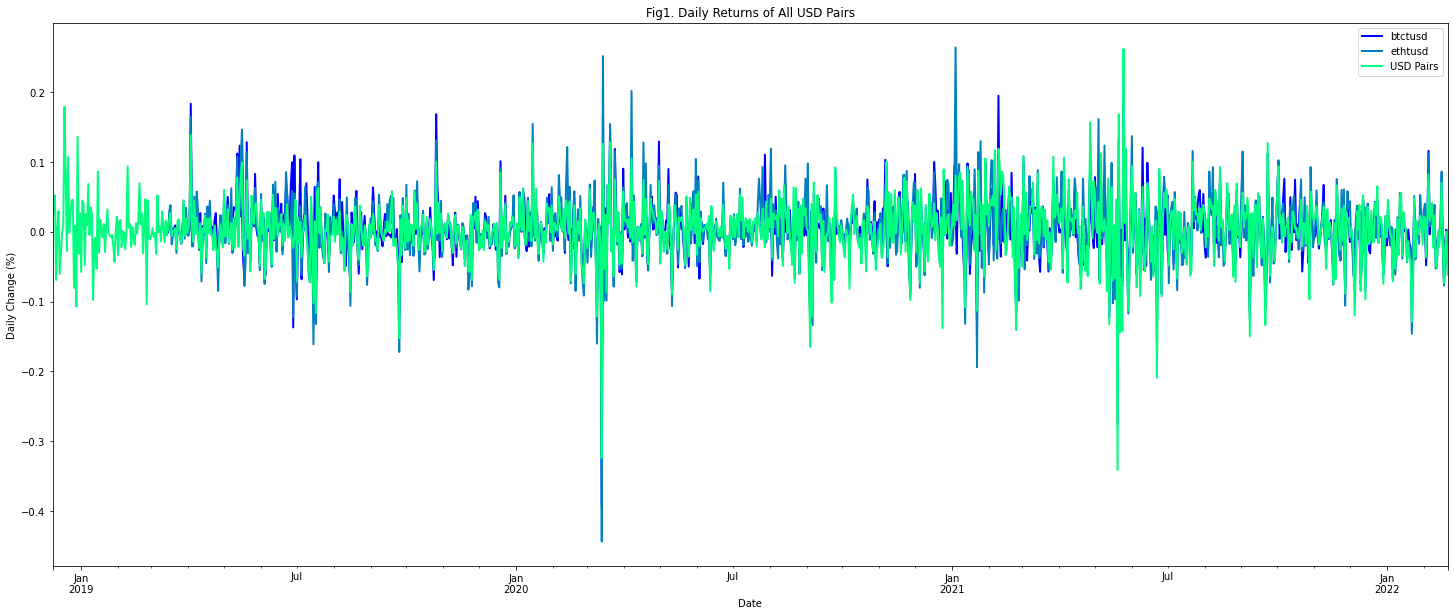

In [63]:
#Plot daily returns of portfolio_usd
daily_returns = returns_df
daily_returns.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig1. Daily Returns of All USD Pairs", ylabel="Daily Change (%)", xlabel="Date")

<AxesSubplot:title={'center':'Fig2. Daily Cumulative Returns of All USD Pairs'}, xlabel='Date', ylabel='Daily Return (%)'>

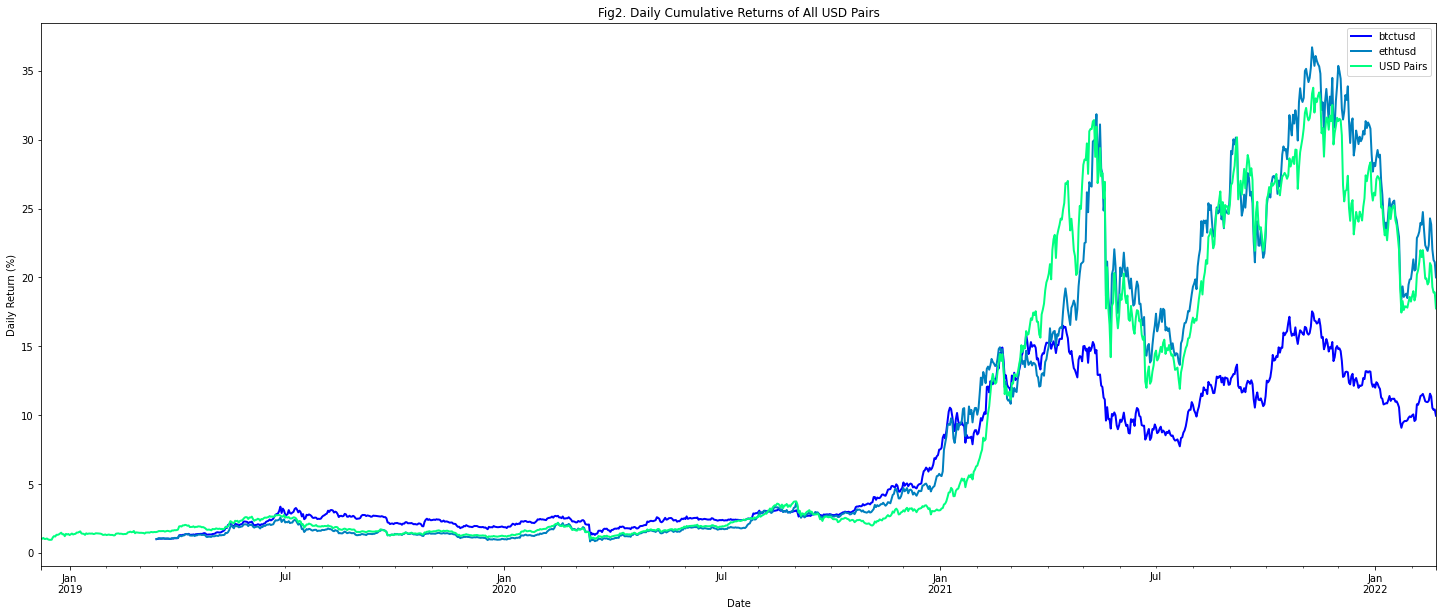

In [64]:
#Calculate and plot cumalative returns
df_cum = (1+ daily_returns).cumprod()
df_cum.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig2. Daily Cumulative Returns of All USD Pairs", ylabel="Daily Return (%)", xlabel="Date")

<AxesSubplot:title={'center':'Fig3. Daily Returns Box Plot'}, ylabel='% Change'>

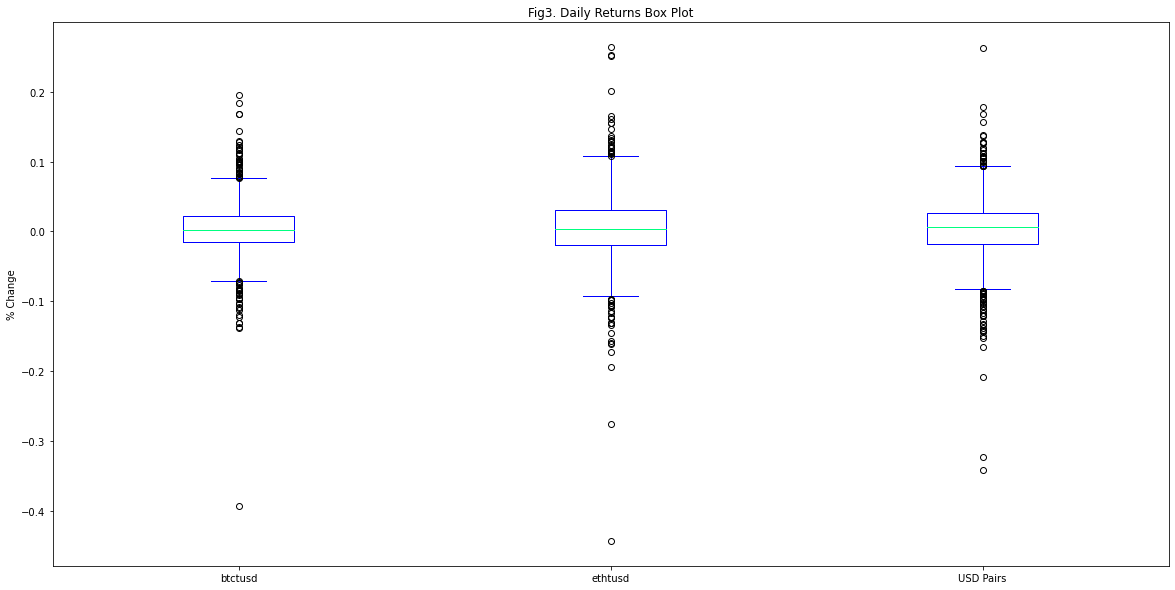

In [65]:
# Create a box plot for each of the returns.
daily_returns.plot(kind = "box", colormap="winter", figsize = (20,10), ylabel="% Change", title="Fig3. Daily Returns Box Plot")

In [66]:
# Daily Standard Deviations
# Calculate the standard deviation for each portfolio.
df_daily_std = pd.DataFrame(daily_returns.std()).rename(columns = {0:"std"})
df_daily_std

,std
btctusd,0.040177
ethtusd,0.050817
USD Pairs,0.045457


In [67]:
#Comparative Analysis of all Portfolios
#luke_daily_change
#combined_df
#returns_df

In [68]:
luke_daily_change.mean().hvplot.bar(title="Luke portfolio average daily returns").opts(yformatter="%.5f")

:Bars   [index]   (0)

In [69]:
combined_df.mean().hvplot.bar(title="Gaetano portfolio average daily returns").opts(yformatter="%.5f")


:Bars   [index]   (0)

In [70]:
returns_df.mean().hvplot.bar(title="Rhoan portfolio average daily returns").opts(yformatter="%.5f")

:Bars   [index]   (0)

In [73]:
#Find the daily returns for the portfolio and insert into the same Df
luke_daily_change["Luke Portfolio"] = luke_daily_change.mean(axis=1)
luke_daily_change.drop(luke_daily_change.columns.difference(["Luke Portfolio"]), 1, inplace=True)
luke_daily_change.head(1)

C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,Luke Portfolio
Date,
2017-01-04,0.005853


In [74]:
combined_df["Gaetano Portfolio"] = combined_df.mean(axis=1)
combined_df.drop(combined_df.columns.difference(["Gaetano Portfolio"]), 1, inplace=True)
combined_df.head(1)

C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,Gaetano Portfolio
Date,
2018-01-18,0.044025


In [75]:
returns_df.head()

,btctusd,ethtusd,USD Pairs
Date,,,
2018-12-08,NaN,NaN,NaN
2018-12-09,NaN,NaN,0.028809
2018-12-10,NaN,NaN,0.052046
2018-12-11,NaN,NaN,-0.069045
2018-12-12,NaN,NaN,0.004675


In [76]:
# compile the list of dataframes you want to merge
data_frames_custom = [luke_daily_change, combined_df, returns_df]
df_custom = reduce(lambda  left,right: pd.merge(left,right,on=["Date"],
                                            how='inner'), data_frames_custom)
df_custom.head()

,Luke Portfolio,Gaetano Portfolio,btctusd,ethtusd,USD Pairs
Date,,,,,
2018-12-10,-0.002149,-0.024113,NaN,NaN,0.052046
2018-12-11,-0.000608,-0.009637,NaN,NaN,-0.069045
2018-12-12,-0.000954,0.012154,NaN,NaN,0.004675
2018-12-13,0.000631,-0.038332,NaN,NaN,0.029629
2018-12-14,-0.009958,-0.022836,NaN,NaN,-0.060275


In [77]:
df_custom.rename(columns = {"USD Pairs":"Rhoan Portfolio"}, inplace = True)
df_custom.head(1)

,Luke Portfolio,Gaetano Portfolio,btctusd,ethtusd,Rhoan Portfolio
Date,,,,,
2018-12-10,-0.002149,-0.024113,NaN,NaN,0.052046


In [78]:
df_custom.mean().hvplot.bar(title="Average Daily Returns for All Portfolios").opts(yformatter="%.5f")

:Bars   [index]   (0)

<AxesSubplot:title={'center':'Average Daily Returns Box Plot'}, ylabel='% Change'>

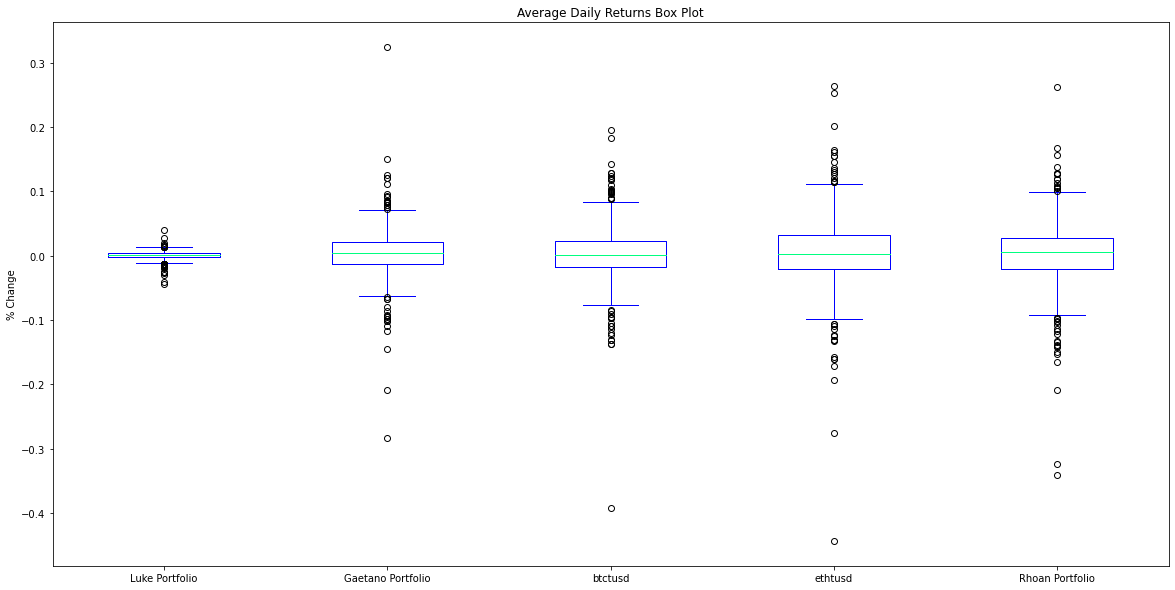

In [107]:
df_custom.plot(kind = "box", colormap="winter", figsize = (20,10), ylabel="% Change", title="Average Daily Returns Box Plot")

In [79]:
# Reset the index
df_custom.index =df_custom.index.normalize()

In [80]:
# Drop Nulls
df_custom.dropna(inplace=True)

In [81]:
# Calculate the weighted returns for your portfolio, assuming equal allocation
weights = [1/5,1/5,1/5,1/5,1/5]
all_portfolio = df_custom.dot(weights)
all_portfolio_returns = all_portfolio.pct_change()
all_portfolio_returns.dropna(inplace = True)
all_portfolio_returns.head()

Date
2019-03-18    -2.228959
2019-03-19    -1.135989
2019-03-20     3.560273
2019-03-21    -0.903021
2019-03-22   -45.502484
dtype: float64

In [82]:
# Only compare dates where return data exists for all the stocks (drop NaNs)
df_custom.dropna(inplace=True)

In [83]:
# Calculate the Annualized Standard Deviation.
portfolio_std = pd.DataFrame(df_custom.std()).rename(columns = {0:"std"})
portfolio_std

,std
Luke Portfolio,0.006396
Gaetano Portfolio,0.037605
btctusd,0.043037
ethtusd,0.054050
Rhoan Portfolio,0.048631


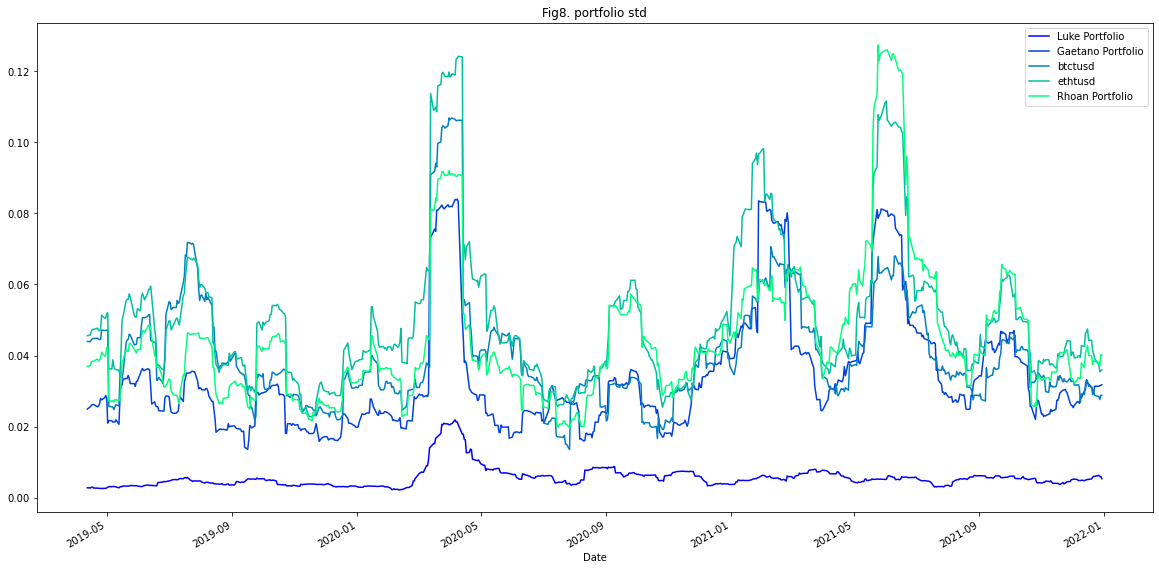

In [84]:
# Calculate and plot rolling std with a 21-day window
my_portfolio_rolling_21 = df_custom.rolling(window = 21).std()
ax = my_portfolio_rolling_21.plot(figsize = (20,10), title = 'Portfolio std', colormap="winter")
ax.legend()

<AxesSubplot:title={'center':'Fig9. Rolling 60-Day Beta of my portfolio'}, xlabel='Date'>

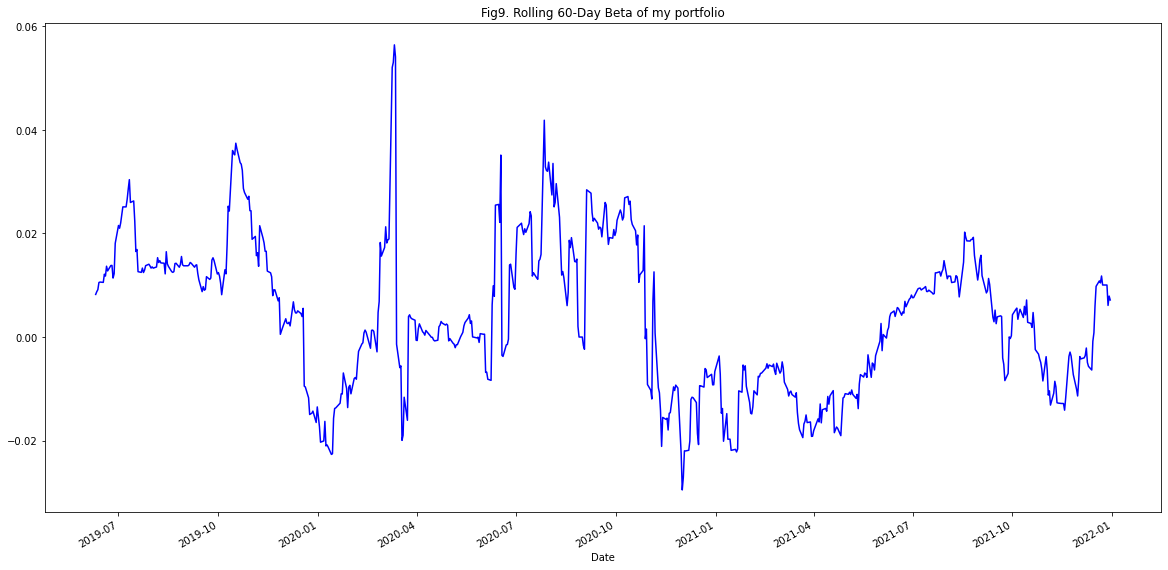

In [85]:
# Calculate and plot the 60-day rolling beta for each portfolio compared to the BTCUSD.
rolling_covariance = df_custom["Luke Portfolio"].rolling(window=60).cov(df_custom["btctusd"])
rolling_variance = df_custom["btctusd"].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title='Rolling 60-Day Beta of my portfolio', colormap="winter")

<AxesSubplot:title={'center':'Fig9. Rolling 60-Day Beta of my portfolio'}, xlabel='Date'>

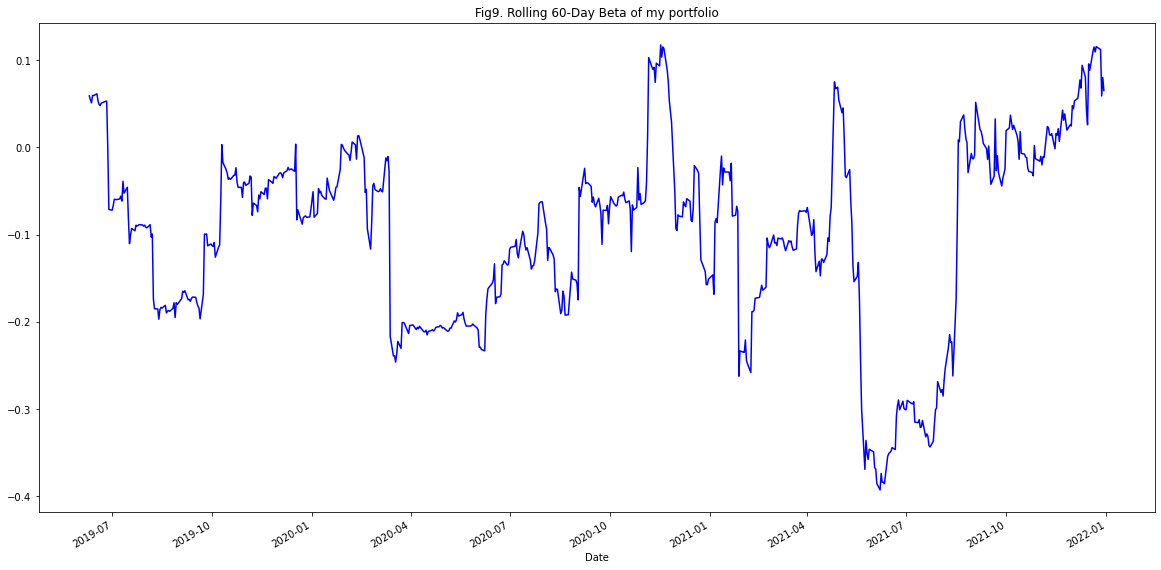

In [86]:
# Calculate and plot the 60-day rolling beta for each portfolio compared to the BTCUSD.
rolling_covariance = df_custom["Gaetano Portfolio"].rolling(window=60).cov(df_custom["btctusd"])
rolling_variance = df_custom["btctusd"].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title='Rolling 60-Day Beta of my portfolio', colormap="winter")

<AxesSubplot:title={'center':'Fig9. Rolling 60-Day Beta of my portfolio'}, xlabel='Date'>

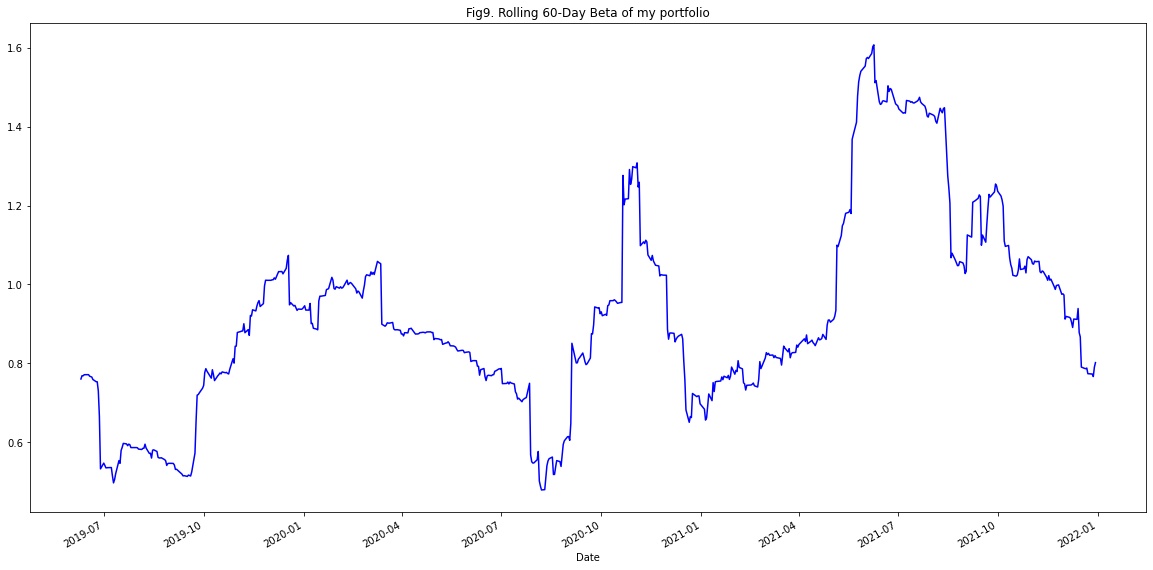

In [87]:
# Calculate and plot the 60-day rolling beta for each portfolio compared to the BTCUSD.
rolling_covariance = df_custom["Rhoan Portfolio"].rolling(window=60).cov(df_custom["btctusd"])
rolling_variance = df_custom["btctusd"].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title='Rolling 60-Day Beta of my portfolio', colormap="winter")

In [88]:
# Calculate the Sharpe ratios and generate a bar plot.
# Annualzied Sharpe Ratios
trading_days = df_custom.count()
sharpe_ratios = df_custom.mean()*trading_days/(df_custom.std()*np.sqrt(trading_days))

<AxesSubplot:title={'center':'Fig10. sharpe ratios'}>

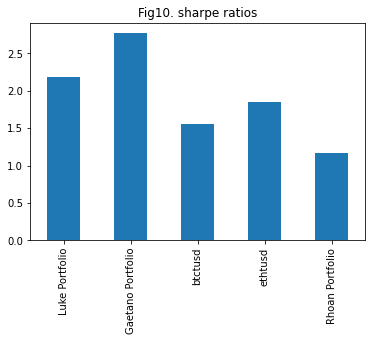

In [89]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind = 'bar', title = "Sharpe Ratios")

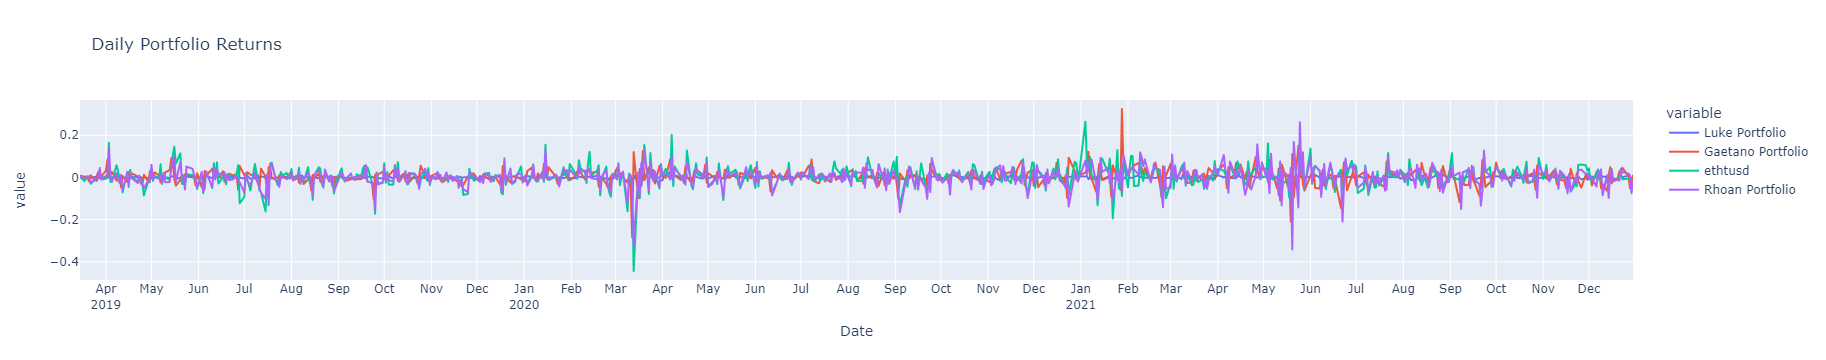

In [104]:
#Use plotly express to come up with visualisation
df = df_custom.reset_index()
fig = px.line(df, x="Date", y=df.columns,
              hover_data={"btctusd": "|%B %d, %Y"},
              title='Daily Portfolio Returns')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()